In [14]:
import pandas as pd
import importlib
import mpt_functions as mpt
importlib.reload(mpt)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from datetime import datetime, timedelta
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [15]:
f1_start = "2020-04-18 00:00:00"
f1_finish = "2020-04-18 23:59:00"
f2_start = "2020-05-29 23:30:00"
f2_finish = "2020-05-30 06:00:00"
f3_start = "2020-06-05 10:00:00"
f3_finish = "2020-06-07 14:30:00"
f4_start = "2020-07-15 14:30:00"
f4_finish = "2020-07-15 19:00:00"
m4_finish = "2020-07-16 00:00:00"

# **************************************************************************************************************#

path = "/Users/esramahmud/IE440/MetroPT3(AirCompressor).csv"
df = mpt.get_the_data_and_convert_datetime(path)

#

df = mpt.drop_a_column(df, "Unnamed: 0")

#

df = df.assign(condition=0)
df = mpt.change_the_values_by_applying_a_time_filter(df, f1_start, f1_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f2_start, f2_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f3_start, f3_finish, "condition", 1)
df = mpt.change_the_values_by_applying_a_time_filter(df, f4_start, f4_finish, "condition", 1)




#

all_column_names = df.columns.to_list()

name_of_the_categorical_columns = ['COMP', 'DV_eletric', 'Towers',
       'MPG', 'LPS', 'Pressure_switch', 'Oil_level', 'Caudal_impulses']

name_of_the_numerical_columns =['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Motor_current']

target_column = df["condition"]

#

df_scaled = mpt.scale_columns(df, name_of_the_numerical_columns)




datetime_column = df.columns[0]  # Adjust this if your datetime column isn't the first one

# Add month and week number columns
df_scaled['number_of_the_month'] = df_scaled[datetime_column].dt.month
df_scaled['number_of_the_week'] = df_scaled[datetime_column].dt.isocalendar().week
df_scaled["number_of_the_day"] = df_scaled[datetime_column].dt.isocalendar().day


df_scaled['number_of_the_month'] = df_scaled['number_of_the_month'].astype('float64')
df_scaled['number_of_the_week'] = (df_scaled['number_of_the_week'].astype('float64') % 4) + 1
df_scaled['number_of_the_day'] = df_scaled['number_of_the_day'].astype('float64')

In [16]:
def aggregate(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8):
    

    result1 = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")

    probabilities = result1[0]
    y_test = result1[1]

    #probabilities = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes")[0]
    #y_test = mpt.get_the_probabilities_with_logistic_regressionn(df, n1, n2, m3, n4, n5, n6, n7, n8, "no")[1]
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition(df_ed, aggregation_size)
    return result


def agg_new_deneme(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):

    result1 = mpt.get_the_probabilities_with_logistic_regressionn_new(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)

    probabilities = result1[0]
    y_test = result1[1]

    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result


def agg_random_forest(n, f, d, s, l, df, aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_random_forest_new(n, f, d, s, l, df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)

    feature_importances = result1[2]

    return result, feature_importances


def agg_single_tree(df,aggregation_size, n1, n2, m3, n4, n5, n6, n7, n8, use1, use2, use3, use4, sliding_amount):


    result1 = mpt.get_the_probabilities_with_single_tree(df, n1, n2, m3, n4, n5, n6, n7, n8, "yes", use1, use2, use3, use4)


    probabilities = result1[0]
    y_test =result1[1]
    
    df_ed = pd.DataFrame({"proba": probabilities, "condition": y_test})
    result = mpt.group_rows_by_condition_sliding(df_ed, aggregation_size, sliding_amount)
    return result



def plot_probabilities_by_condition(df, threshold): # tekrar yazılacak

    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    
    # Add labels and title
    plt.title('Probablity of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [17]:
def plot_probabilities_by_condition2(df, threshold):
    import matplotlib.pyplot as plt
    import numpy as np

    print(df)

    indices = np.arange(df.shape[0])
    
    # Create figure
    plt.figure(figsize=(8, 5))
    
    # Plot points with condition=0 and proba <= threshold in blue
    mask_0_below = (df['condition'] == 0) & (df['proba'] <= threshold)
    plt.scatter(indices[mask_0_below], df.loc[mask_0_below, 'proba'], 
                color='blue', alpha=0.7, label='condition=0')
    
    # Plot points with condition=0 and proba > threshold in red
    mask_0_above = (df['condition'] == 0) & (df['proba'] > threshold)
    plt.scatter(indices[mask_0_above], df.loc[mask_0_above, 'proba'], 
                color='red', alpha=0.7, label=f'condition=0, proba>{threshold}')
    
    # Plot points with condition=1 in black
    mask_1 = df['condition'] == 1
    plt.scatter(indices[mask_1], df.loc[mask_1, 'proba'], 
                color='black', alpha=0.7, label='condition=1')

    # Set y-axis range
    plt.ylim(0, 1)
    
    # Add labels and title
    plt.title('Probability of Failure')
    plt.xlabel('Index')
    plt.ylabel('Probability')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    
    # Show the plot
    plt.tight_layout()
    plt.show()


In [18]:
df_back_up = df_scaled.copy()

In [19]:
df = df_back_up.copy()

df1 = df.copy() # best but suspicious

In [20]:
def simulate_preventive_maintenance(df, f4_start_str, f4_finish_str, n_points):
    """
    4. arıza dönemi çıkarılır ve arıza maintenance sonrası veriler,
    f4_start'tan n_points önceki zamana kaydırılır.

    Parametreler:
    - df: DataFrame, içinde 'timestamp' kolonu olmalı (datetime formatında)
    - f4_start_str: str, 4. arızanın başlangıç zamanı ("YYYY-MM-DD HH:MM:SS")
    - f4_finish_str: str, 4. arızanın bitiş zamanı ("YYYY-MM-DD HH:MM:SS")
    - n_points: int, kaydırma için kullanılacak nokta sayısı (varsayılan: 2400)

    Dönüş: Yeni düzenlenmiş DataFrame
    """

    
    f4_start = pd.to_datetime(f4_start_str)
    f4_finish = pd.to_datetime(f4_finish_str)

    
    if not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
        df = df.copy()
        df['timestamp'] = pd.to_datetime(df['timestamp'])

    # 4. arıza başlangıç index'ini bul
    try:
        f4_index = df[df['timestamp'] == f4_start].index[0]
    except IndexError:
        raise ValueError("f4_start zamanı DataFrame içinde bulunamadı.")

    # 2400 veri öncesi hedef index
    target_index = max(f4_index - n_points, 0)
    target_time = df.loc[target_index, 'timestamp']

    # Arıza sonrası veriyi al
    df_after = df[df['timestamp'] > f4_finish].copy()

    if not df_after.empty:
        # İlk timestamp'e göre kaydırılacak süre hesapla
        shift_duration = df_after.iloc[0]['timestamp'] - target_time
        df_after['timestamp'] = df_after['timestamp'] - shift_duration
    else:
        shift_duration = pd.Timedelta(0)

    # Arıza öncesi veriler
    df_before = df[df['timestamp'] < f4_start].copy()

    # Yeni DataFrame
    df_simulated = pd.concat([df_before, df_after], ignore_index=True)
    df_simulated = df_simulated.sort_values('timestamp').reset_index(drop=True)

    return df_simulated



In [21]:
df_simulated = simulate_preventive_maintenance(df1, f4_start, m4_finish, 500)

In [22]:
df1[df1["timestamp"] >= "2020-07-15 16:00:00"]

timestamp       TP2       TP3        H1  DV_pressure  \
1171638 2020-07-15 16:00:03  2.432589 -0.157427 -2.270538    -0.167249   
1171639 2020-07-15 16:00:12  1.873980 -0.110485 -2.271138    -0.172479   
1171640 2020-07-15 16:00:22  2.390755 -0.329545 -2.271138    -0.172479   
1171641 2020-07-15 16:00:32  2.391985 -0.342063 -2.271138    -0.167249   
1171642 2020-07-15 16:00:42  2.393831 -0.332675 -2.271138    -0.167249   
...                     ...       ...       ...       ...          ...   
1516943 2020-09-01 03:59:10 -0.425056 -0.104227  0.401370    -0.203860   
1516944 2020-09-01 03:59:20 -0.425056 -0.126133  0.395970    -0.198629   
1516945 2020-09-01 03:59:30 -0.425056 -0.148039  0.392369    -0.203860   
1516946 2020-09-01 03:59:40 -0.424441 -0.169945  0.388769    -0.203860   
1516947 2020-09-01 03:59:50 -0.425056 -0.194980  0.383969    -0.203860   

         Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  \
1171638   -0.164863         3.680151       1.632165   0.0         1.0     1.0   
1171639   -0.117864         3.672478       1.502932   0.0         1.0     0.0   
1171640   -0.337194         3.649459       1.606101   0.0         1.0     0.0   
1171641   -0.346594         3.672478       1.620219   0.0         1.0     0.0   
1171642   -0.340328         3.657132       1.603929   0.0         1.0     0.0   
...             ...              ...            ...   ...         ...     ...   
1516943   -0.105331        -0.455657      -0.872122   1.0         0.0     1.0   
1516944   -0.127264        -0.467167      -0.871036   1.0         0.0     1.0   
1516945   -0.146064        -0.467167      -0.872122   1.0         0.0     1.0   
1516946   -0.167997        -0.474840      -0.871036   1.0         0.0     1.0   
1516947   -0.189930        -0.486350      -0.872122   1.0         0.0     1.0   

         MPG  LPS  Pressure_switch  Oil_level  Caudal_impulses  condition  \
1171638  0.0  0.0              1.0        1.0              1.0          1   
1171639  0.0  0.0              0.0        1.0              1.0          1   
1171640  0.0  0.0              1.0        1.0              1.0          1   
1171641  0.0  0.0              1.0        1.0              1.0          1   
1171642  0.0  0.0              1.0        1.0              1.0          1   
...      ...  ...              ...        ...              ...        ...   
1516943  1.0  0.0              1.0        1.0              1.0          0   
1516944  1.0  0.0              1.0        1.0              1.0          0   
1516945  1.0  0.0              1.0        1.0              1.0          0   
1516946  1.0  0.0              1.0        1.0              1.0          0   
1516947  1.0  0.0              1.0        1.0              1.0          0   

         number_of_the_month  number_of_the_week  number_of_the_day  
1171638                  7.0                 2.0                3.0  
1171639                  7.0                 2.0                3.0  
1171640                  7.0                 2.0                3.0  
1171641                  7.0                 2.0                3.0  
1171642                  7.0                 2.0                3.0  
...                      ...                 ...                ...  
1516943                  9.0                 1.0                2.0  
1516944                  9.0                 1.0                2.0  
1516945                  9.0                 1.0                2.0  
1516946                  9.0                 1.0                2.0  
1516947                  9.0                 1.0                2.0  

[345310 rows x 20 columns]

In [23]:
df_simulated[df_simulated["timestamp"] >= "2020-07-15 16:00:00"]

timestamp       TP2       TP3        H1  DV_pressure  \
1172137 2020-07-15 16:00:02 -0.423825  0.249398  0.468572    -0.188169   
1172138 2020-07-15 16:00:12 -0.423825  0.221234  0.463172    -0.188169   
1172139 2020-07-15 16:00:22 -0.423825  0.199328  0.458972    -0.188169   
1172140 2020-07-15 16:00:32 -0.423825  0.171163  0.454172    -0.188169   
1172141 2020-07-15 16:00:42 -0.423210  0.149257  0.448772    -0.188169   
...                     ...       ...       ...       ...          ...   
1513547 2020-08-31 17:06:26 -0.425056 -0.104227  0.401370    -0.203860   
1513548 2020-08-31 17:06:36 -0.425056 -0.126133  0.395970    -0.198629   
1513549 2020-08-31 17:06:46 -0.425056 -0.148039  0.392369    -0.203860   
1513550 2020-08-31 17:06:56 -0.424441 -0.169945  0.388769    -0.203860   
1513551 2020-08-31 17:07:06 -0.425056 -0.194980  0.383969    -0.203860   

         Reservoirs  Oil_temperature  Motor_current  COMP  DV_eletric  Towers  \
1172137    0.251864         0.718329      -0.872122   1.0         0.0     1.0   
1172138    0.223664         0.683800      -0.873208   1.0         0.0     1.0   
1172139    0.198598         0.645434      -0.873208   1.0         0.0     1.0   
1172140    0.173532         0.614742      -0.873208   1.0         0.0     1.0   
1172141    0.148466         0.599396      -0.872122   1.0         0.0     1.0   
...             ...              ...            ...   ...         ...     ...   
1513547   -0.105331        -0.455657      -0.872122   1.0         0.0     1.0   
1513548   -0.127264        -0.467167      -0.871036   1.0         0.0     1.0   
1513549   -0.146064        -0.467167      -0.872122   1.0         0.0     1.0   
1513550   -0.167997        -0.474840      -0.871036   1.0         0.0     1.0   
1513551   -0.189930        -0.486350      -0.872122   1.0         0.0     1.0   

         MPG  LPS  Pressure_switch  Oil_level  Caudal_impulses  condition  \
1172137  1.0  0.0              1.0        1.0              1.0          0   
1172138  1.0  0.0              1.0        1.0              1.0          0   
1172139  1.0  0.0              1.0        1.0              1.0          0   
1172140  1.0  0.0              1.0        1.0              1.0          0   
1172141  1.0  0.0              1.0        1.0              1.0          0   
...      ...  ...              ...        ...              ...        ...   
1513547  1.0  0.0              1.0        1.0              1.0          0   
1513548  1.0  0.0              1.0        1.0              1.0          0   
1513549  1.0  0.0              1.0        1.0              1.0          0   
1513550  1.0  0.0              1.0        1.0              1.0          0   
1513551  1.0  0.0              1.0        1.0              1.0          0   

         number_of_the_month  number_of_the_week  number_of_the_day  
1172137                  7.0                 2.0                4.0  
1172138                  7.0                 2.0                4.0  
1172139                  7.0                 2.0                4.0  
1172140                  7.0                 2.0                4.0  
1172141                  7.0                 2.0                4.0  
...                      ...                 ...                ...  
1513547                  9.0                 1.0                2.0  
1513548                  9.0                 1.0                2.0  
1513549                  9.0                 1.0                2.0  
1513550                  9.0                 1.0                2.0  
1513551                  9.0                 1.0                2.0  

[341415 rows x 20 columns]

RANDOM FOREST MODEL WITH ORIGINAL DATA

                     Importance
DV_pressure            0.895269
number_of_the_day      0.077475
Oil_temperature        0.025473
TP3                    0.000971
MPG                    0.000315
COMP                   0.000314
TP2                    0.000118
H1                     0.000038
Reservoirs             0.000019
Motor_current          0.000008
DV_eletric             0.000000
LPS                    0.000000
Pressure_switch        0.000000
Oil_level              0.000000
Caudal_impulses        0.000000
number_of_the_month    0.000000
number_of_the_week     0.000000
Towers                 0.000000
R-squareddd: 0.9956732557846275
F-Value Like: 1282590.3104185967
model preditions
[0 0 0 ... 0 0 0]
model proba
[0. 0. 0. ... 0. 0. 0.]
        model_predictions  model_probablities
0                       0                 0.0
1                       0                 0.0
2                       0                 0.0
3                       0                 0.0
4                       0 

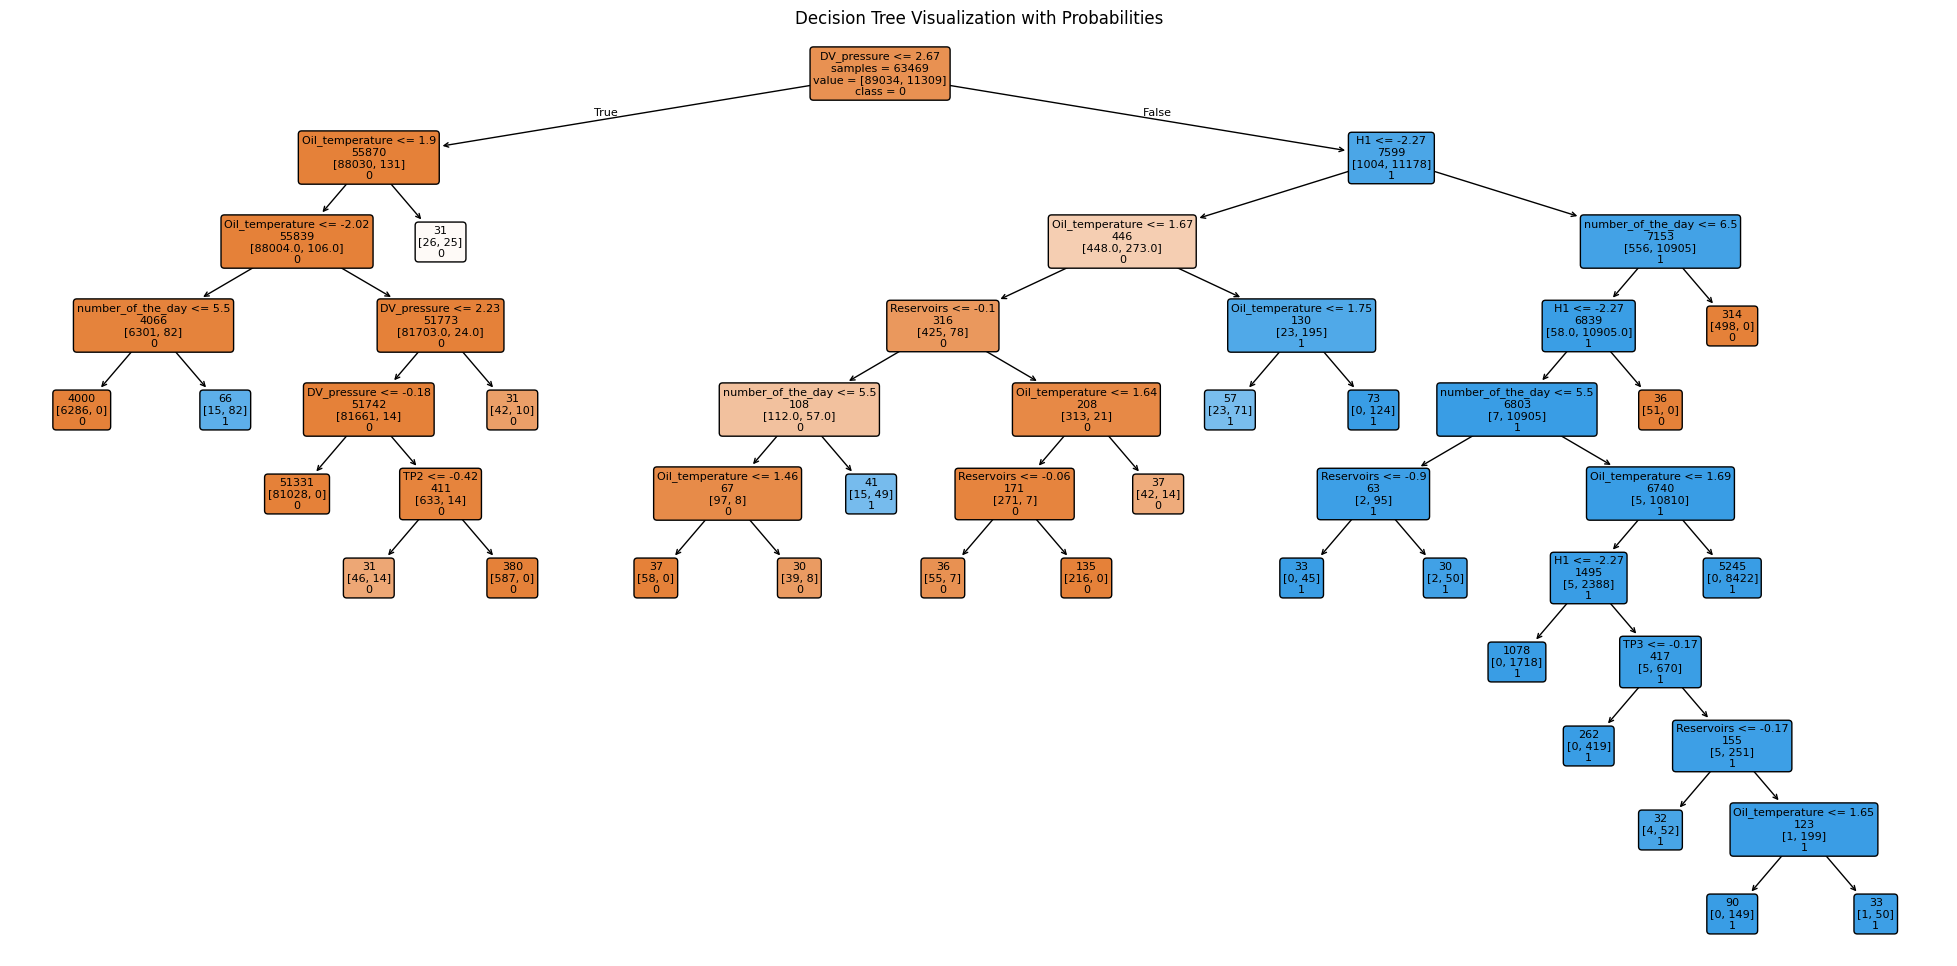

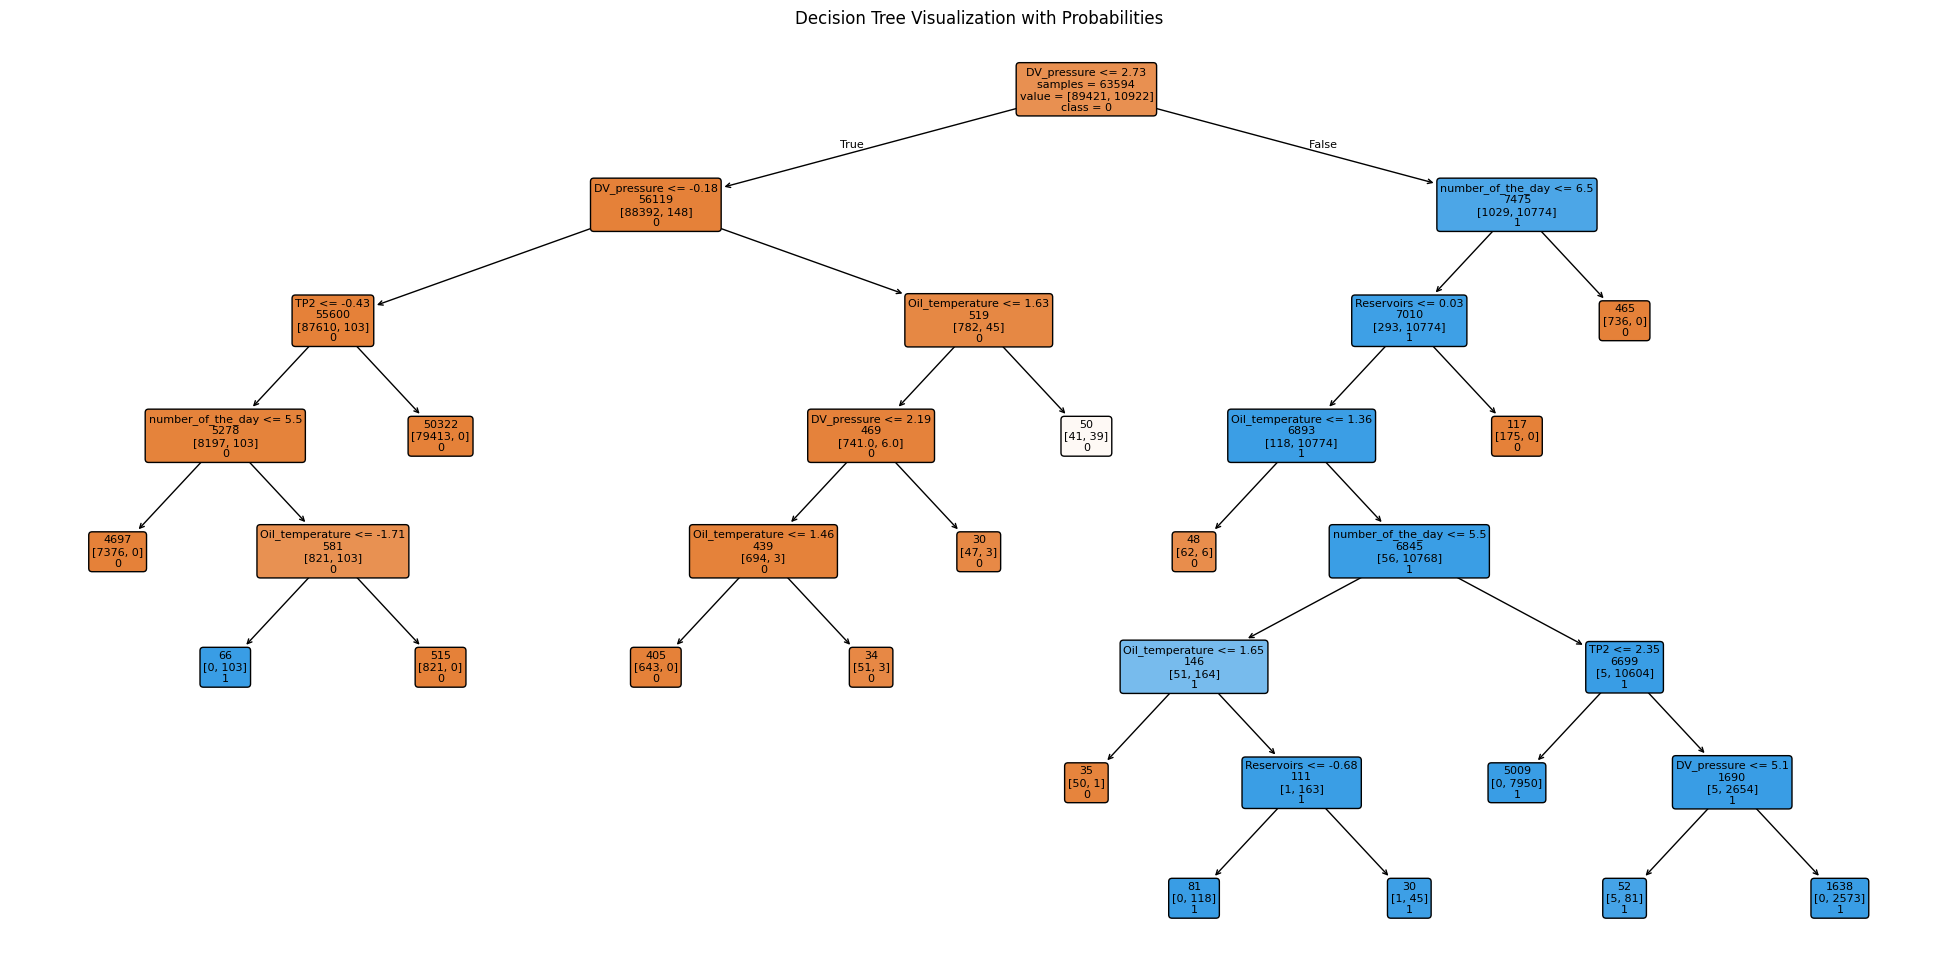

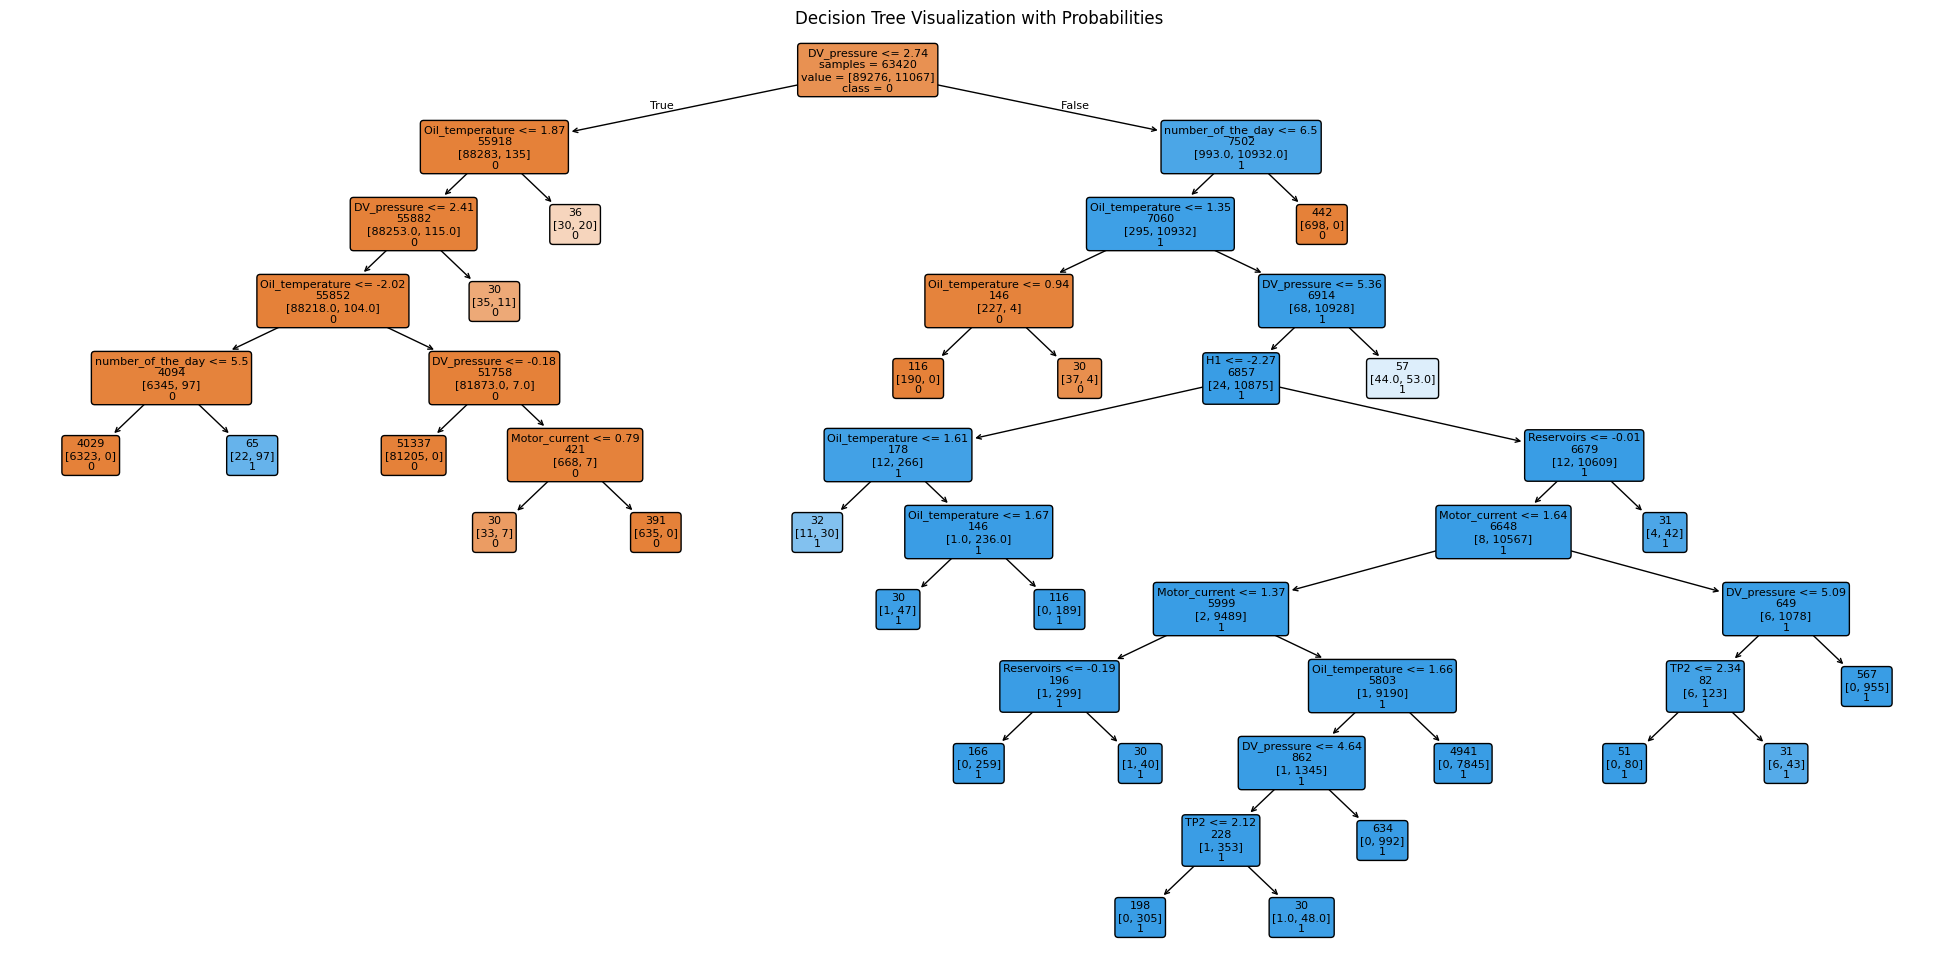

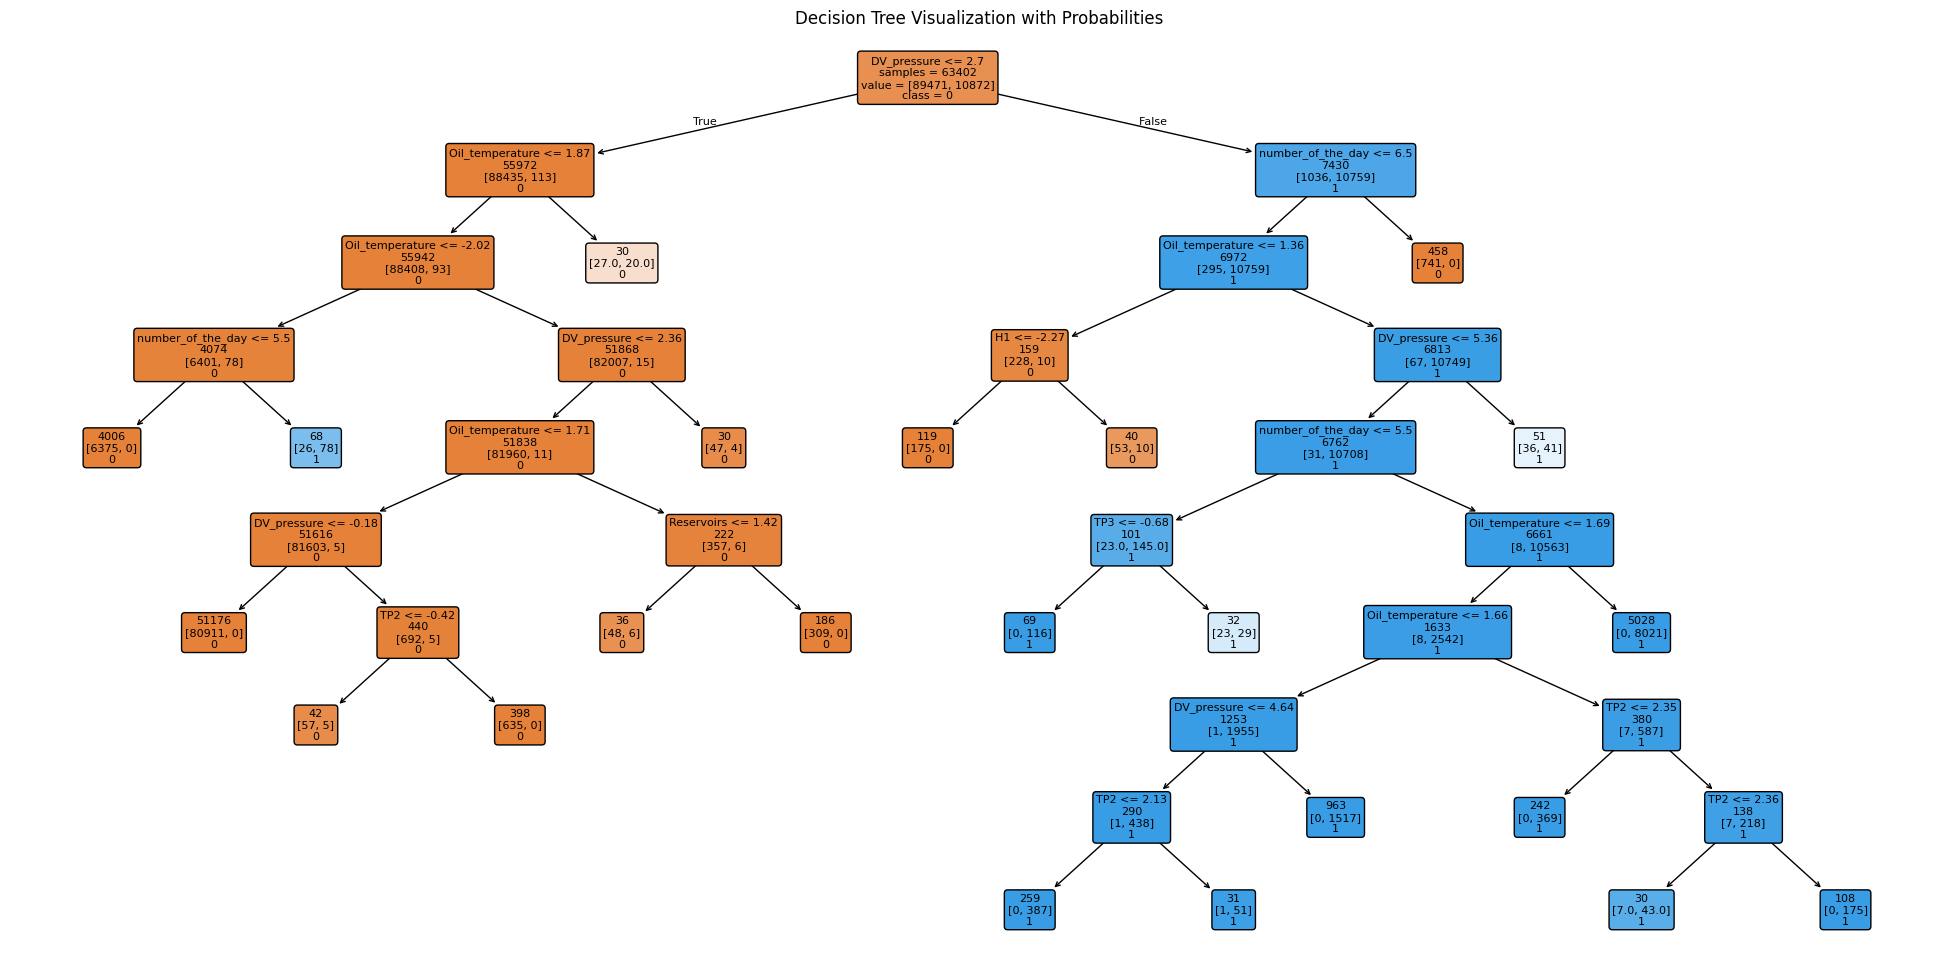

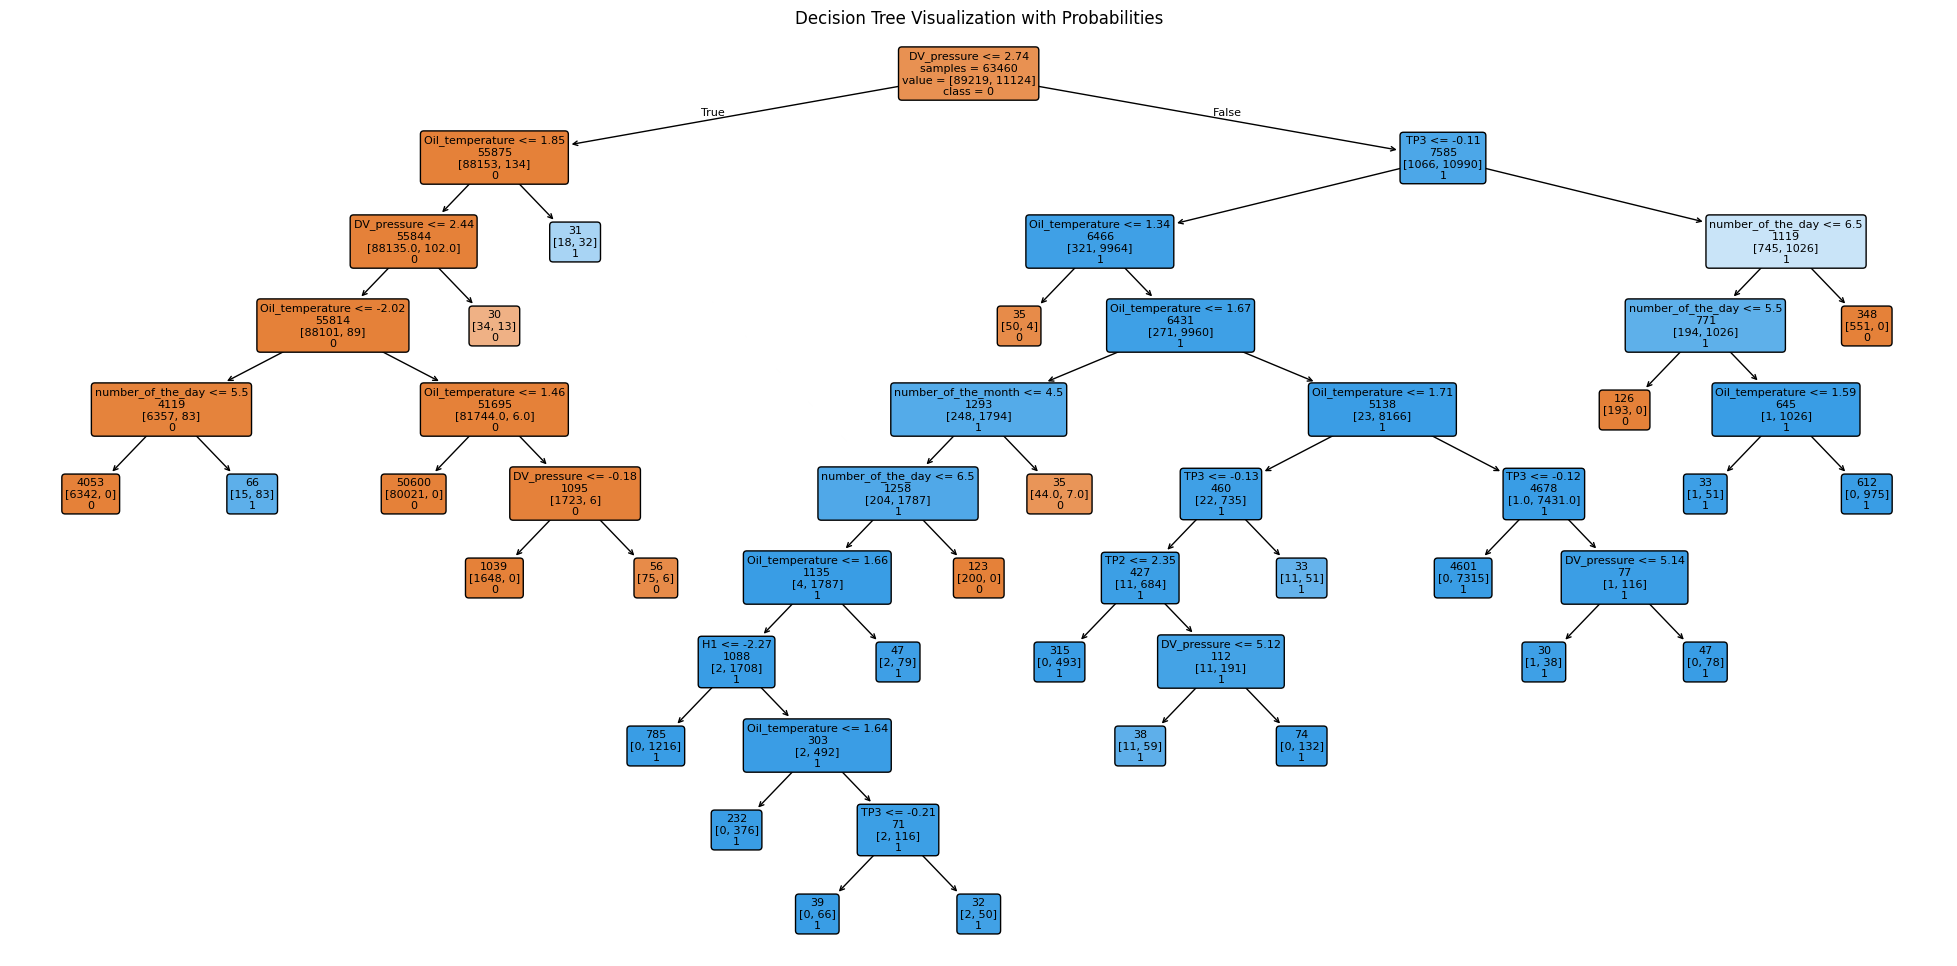

      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000000          0
1            1        100      499        400  0.000000          0
2            2        200      599        400  0.017089          0
3            3        300      699        400  0.020409          0
4            4        400      799        400  0.031811          0
...        ...        ...      ...        ...       ...        ...
5211      5211     521100   521499        400  0.000200          0
5212      5212     521200   521599        400  0.000000          0
5213      5213     521300   521699        400  0.001114          0
5214      5214     521400   521799        400  0.001114          0
5215      5215     521500   521850        351  0.001270          0

[5216 rows x 6 columns]


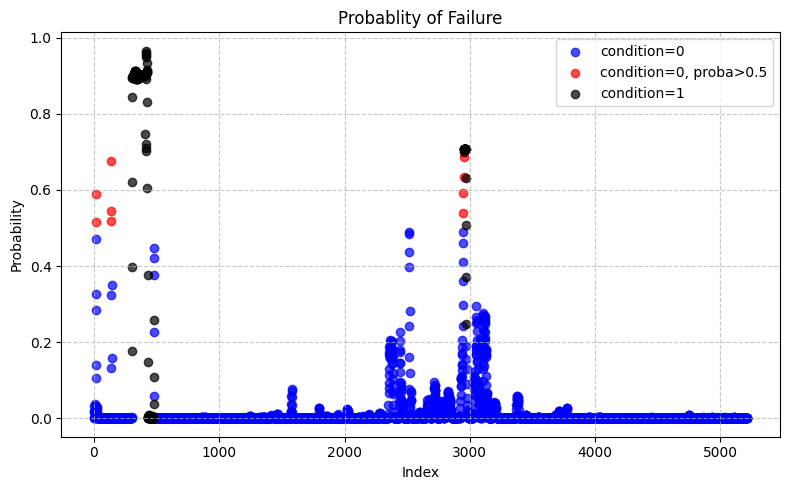

In [24]:

aggregation_size = 400

treshold_probability = 0.5

dataframe = df1

aggregated_probabilities, f2 = agg_random_forest(5, 15, 20, 60, 30, dataframe, aggregation_size, 4, 2, 4, 2, 4, 18, 18, 30, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

RANDOM FOREST MODEL WITH POST MAINTENANCE DATA OF THE 4TH FAILURE

                     Importance
DV_pressure            0.895269
number_of_the_day      0.077475
Oil_temperature        0.025473
TP3                    0.000971
MPG                    0.000315
COMP                   0.000314
TP2                    0.000118
H1                     0.000038
Reservoirs             0.000019
Motor_current          0.000008
DV_eletric             0.000000
LPS                    0.000000
Pressure_switch        0.000000
Oil_level              0.000000
Caudal_impulses        0.000000
number_of_the_month    0.000000
number_of_the_week     0.000000
Towers                 0.000000
R-squareddd: 0.9956732557846275
F-Value Like: 1282590.3104185967
model preditions
[0 0 0 ... 1 1 0]
model proba
[0.         0.         0.         ... 0.53333333 0.53333333 0.024     ]
       model_predictions  model_probablities
0                      0            0.000000
1                      0            0.000000
2                      0            0.000000
3                      0    

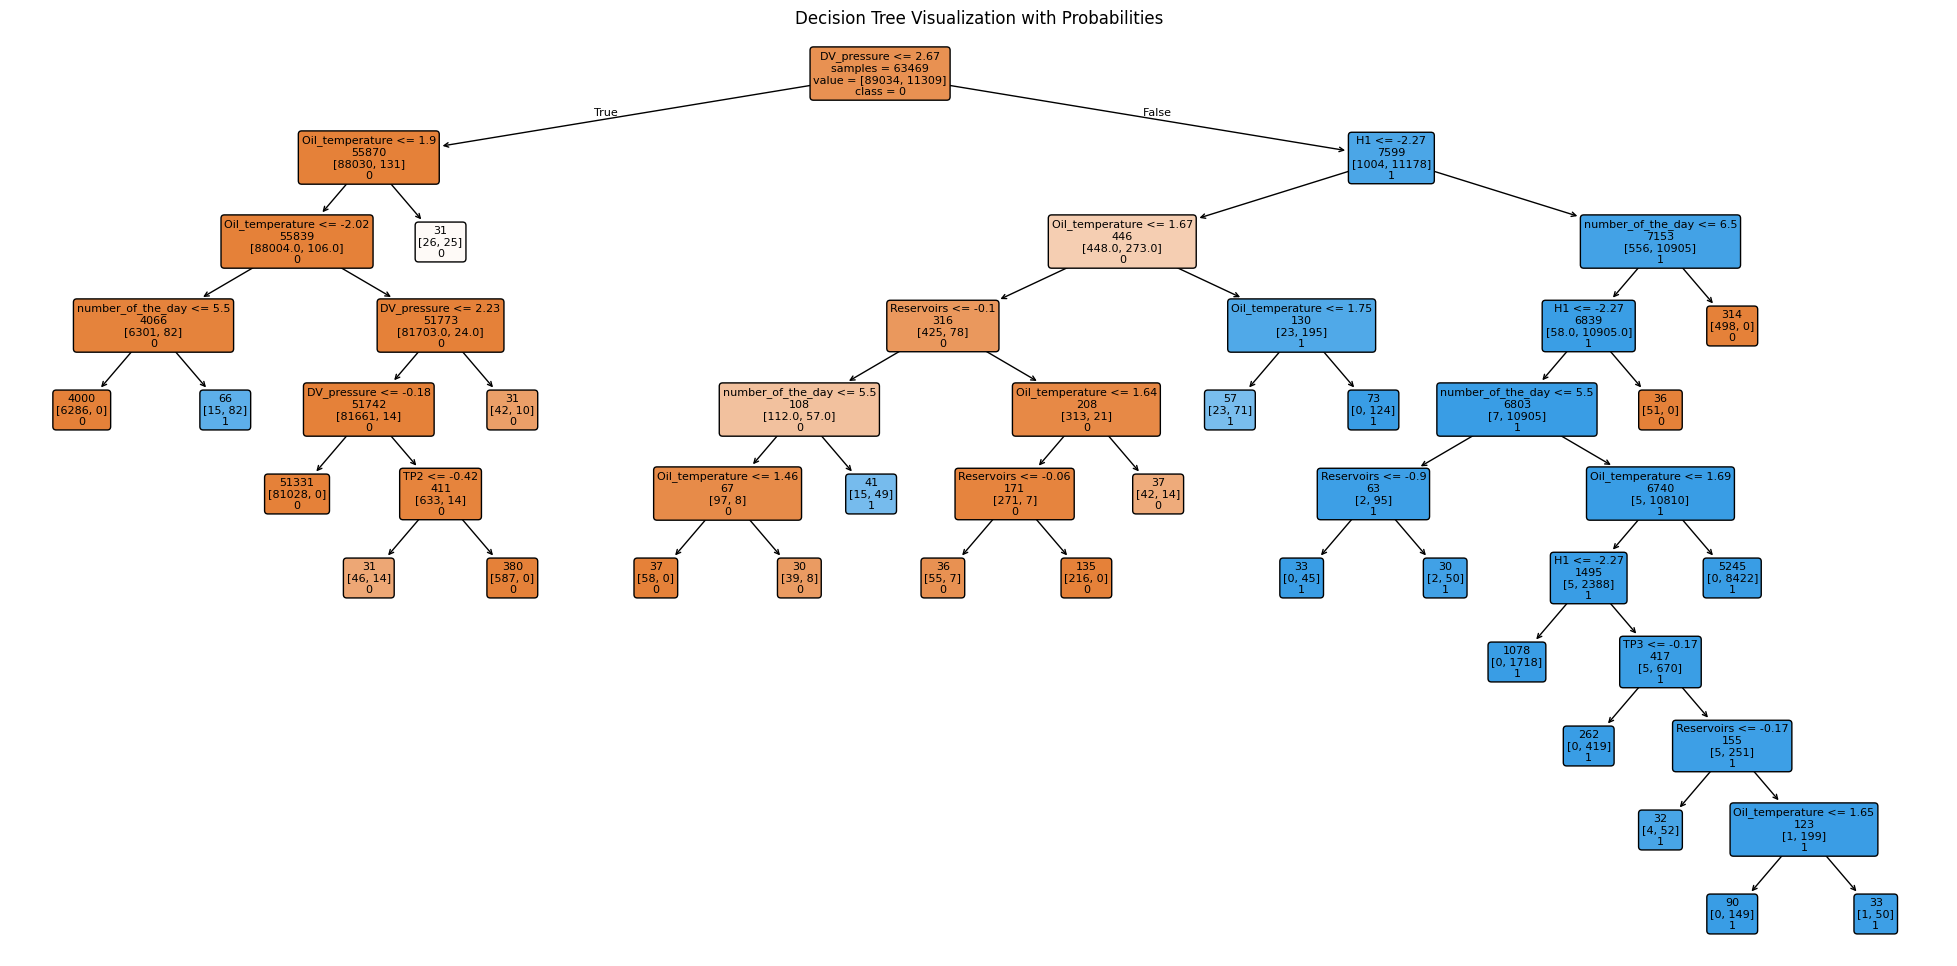

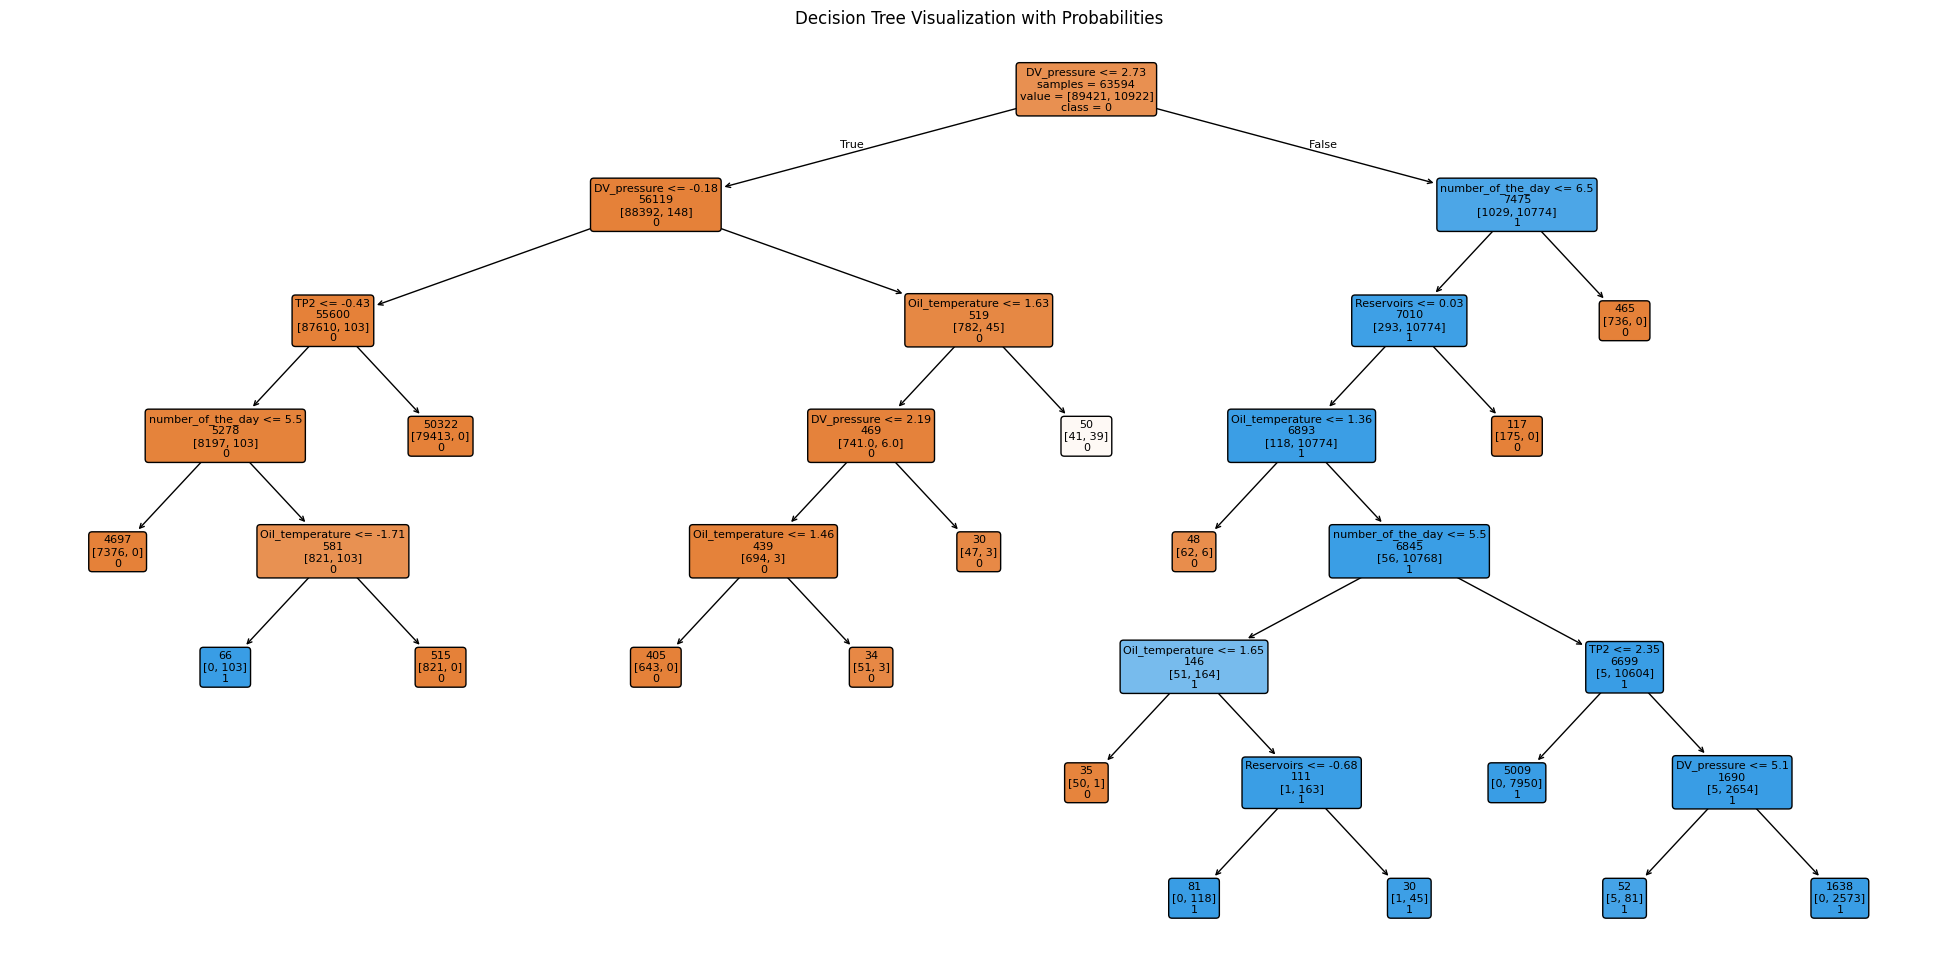

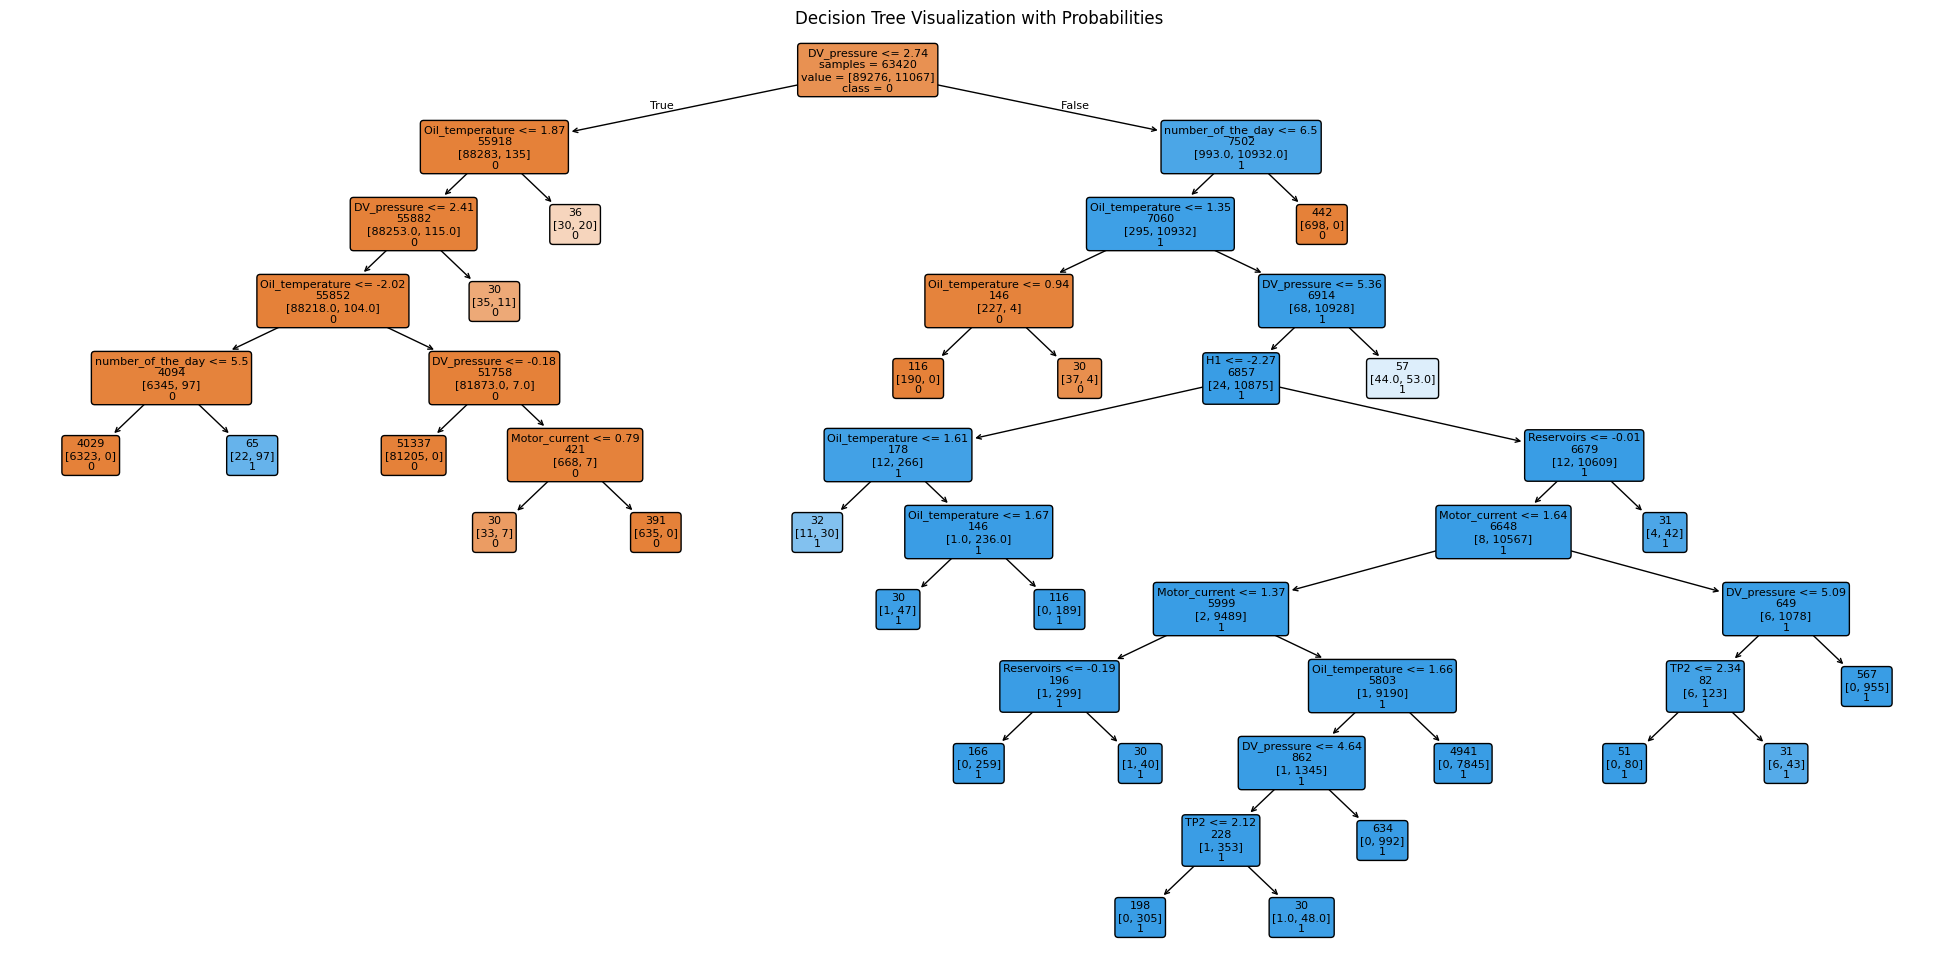

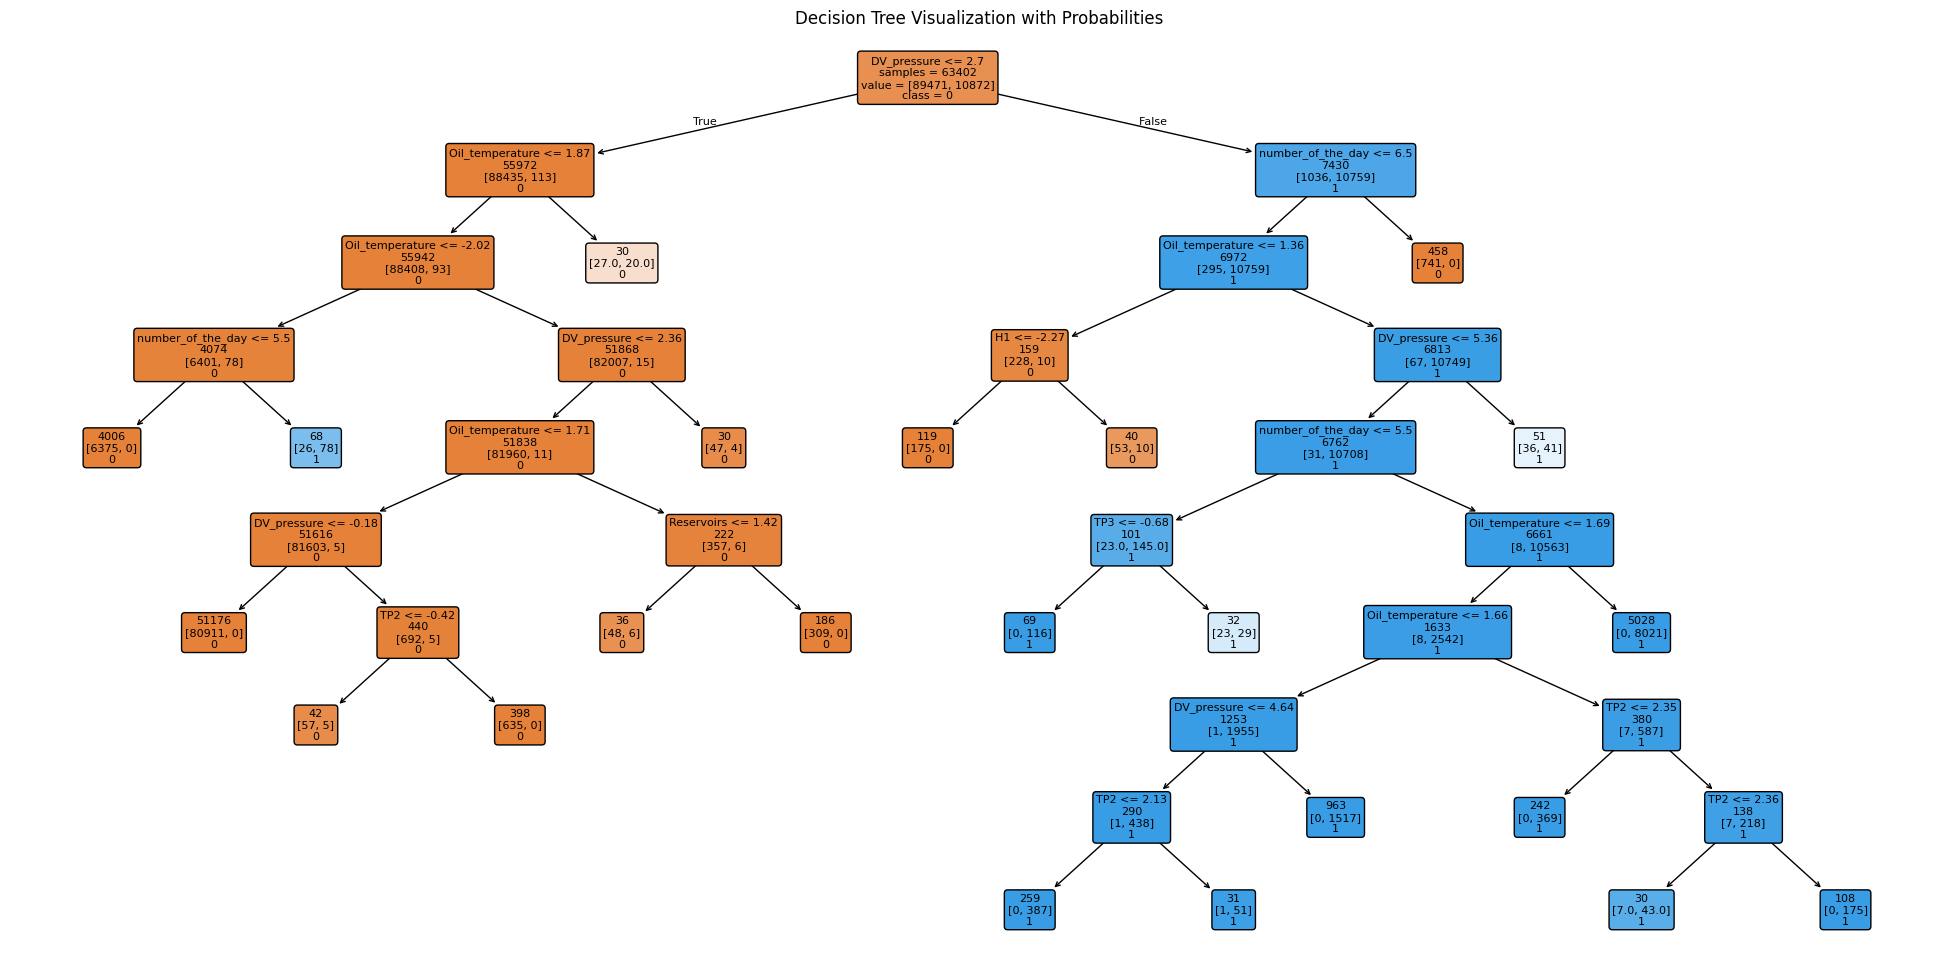

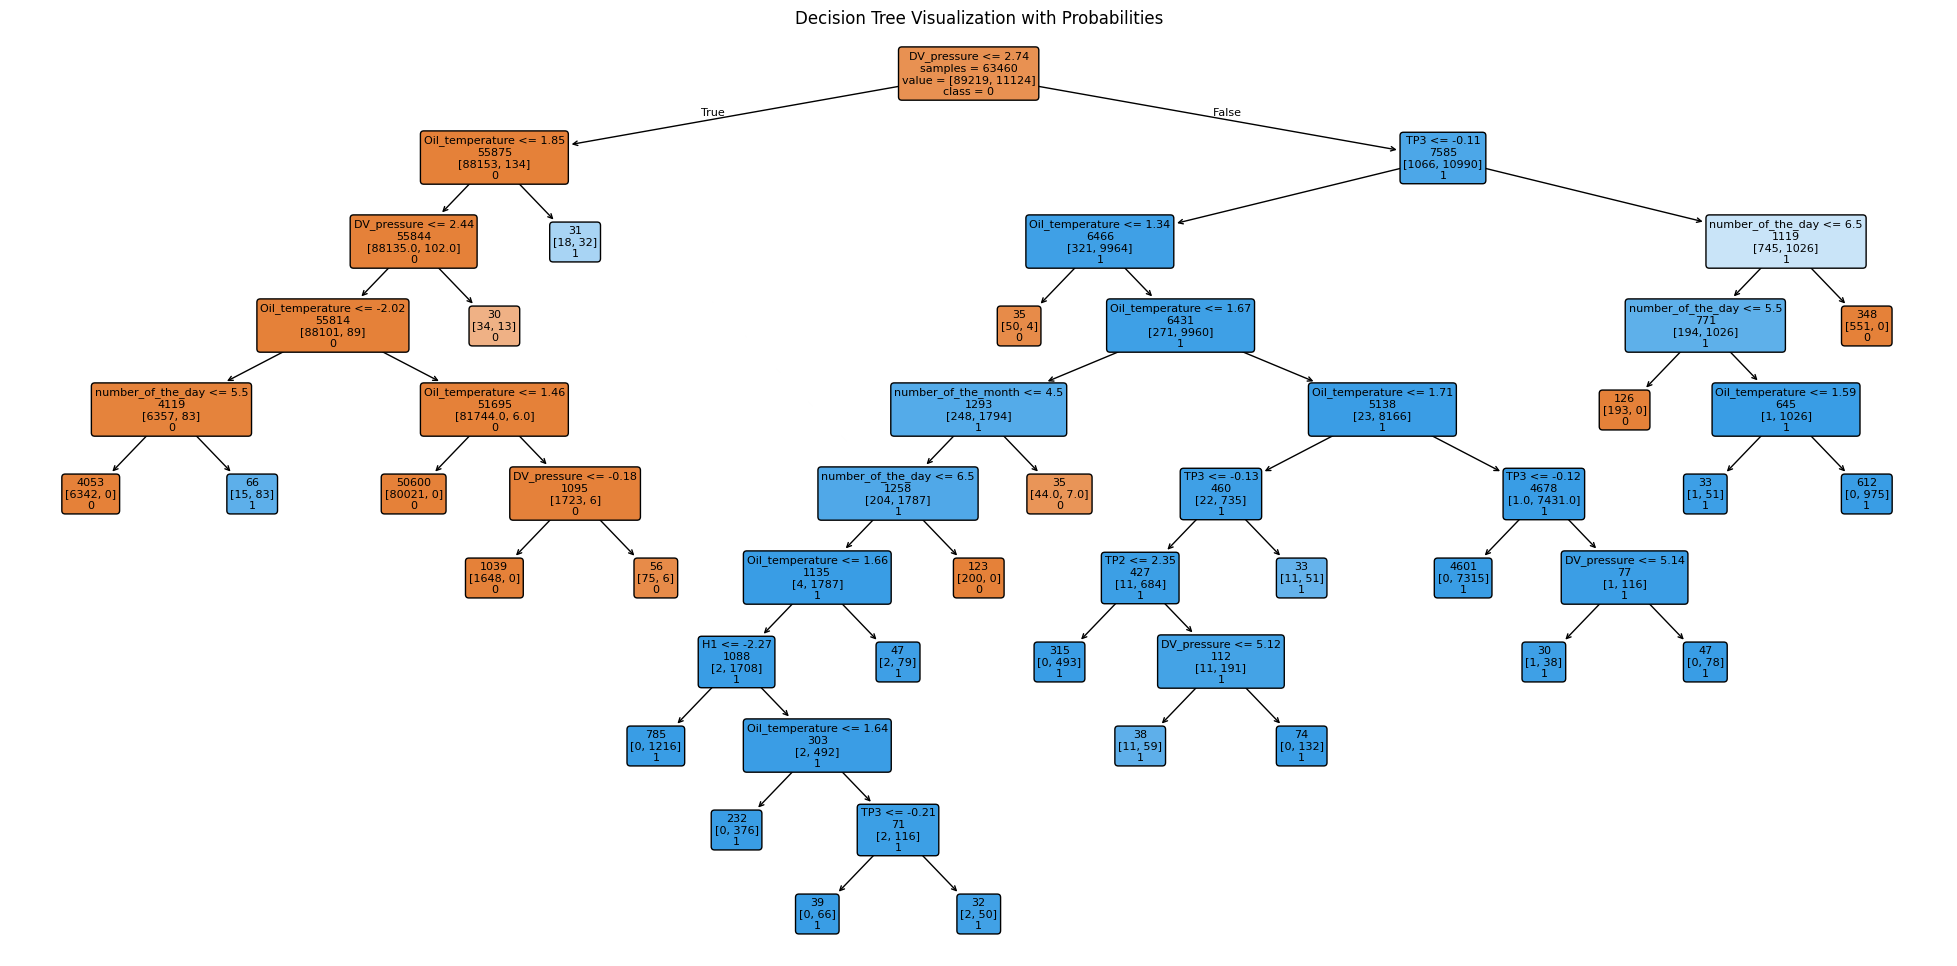

     group_id  start_row  end_row  row_count     proba  condition
0           0          0      399        400  0.000000          0
1           1        100      499        400  0.000000          0
2           2        200      599        400  0.017089          0
3           3        300      699        400  0.020409          0
4           4        400      799        400  0.031811          0
..        ...        ...      ...        ...       ...        ...
781       781      78100    78499        400  0.038142          0
782       782      78200    78599        400  0.020628          0
783       783      78300    78699        400  0.071793          0
784       784      78400    78799        400  0.195016          0
785       785      78500    78875        376  0.220825          0

[786 rows x 6 columns]


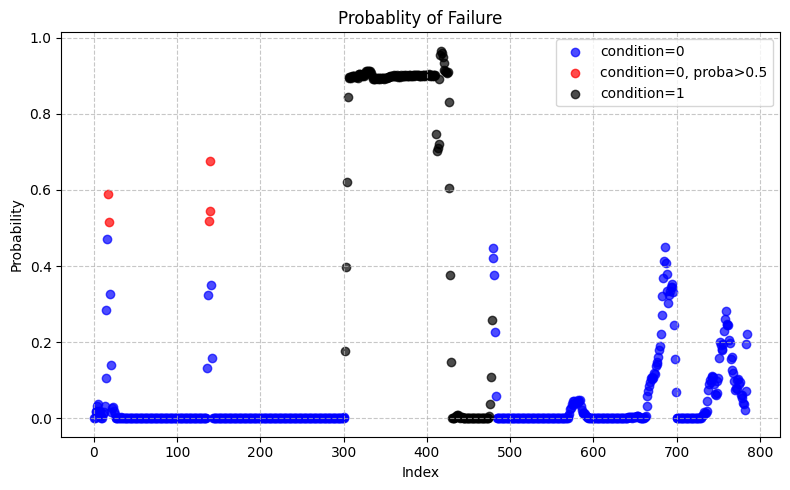

In [25]:
aggregation_size = 400

treshold_probability = 0.5

dataframe = df_simulated

aggregated_probabilities, f2 = agg_random_forest(5, 15, 20, 60, 30, dataframe, aggregation_size, 4, 2, 4, 2, 4, 2, 2, 1, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition(aggregated_probabilities, treshold_probability)

RANDOM FOREST MODEL AFTER FEATURE IMPORTANCE STEPS WITH ORIGINAL DATA

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.00015672 0.00015672 0.00015672 ... 0.00015672 0.00015672 0.00015672]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
444443                  0            0.000157
444444                  0            0.000157
444445                  0            0.000157
444446                  0            0.000157
444447                  0            0.000157

[444448 

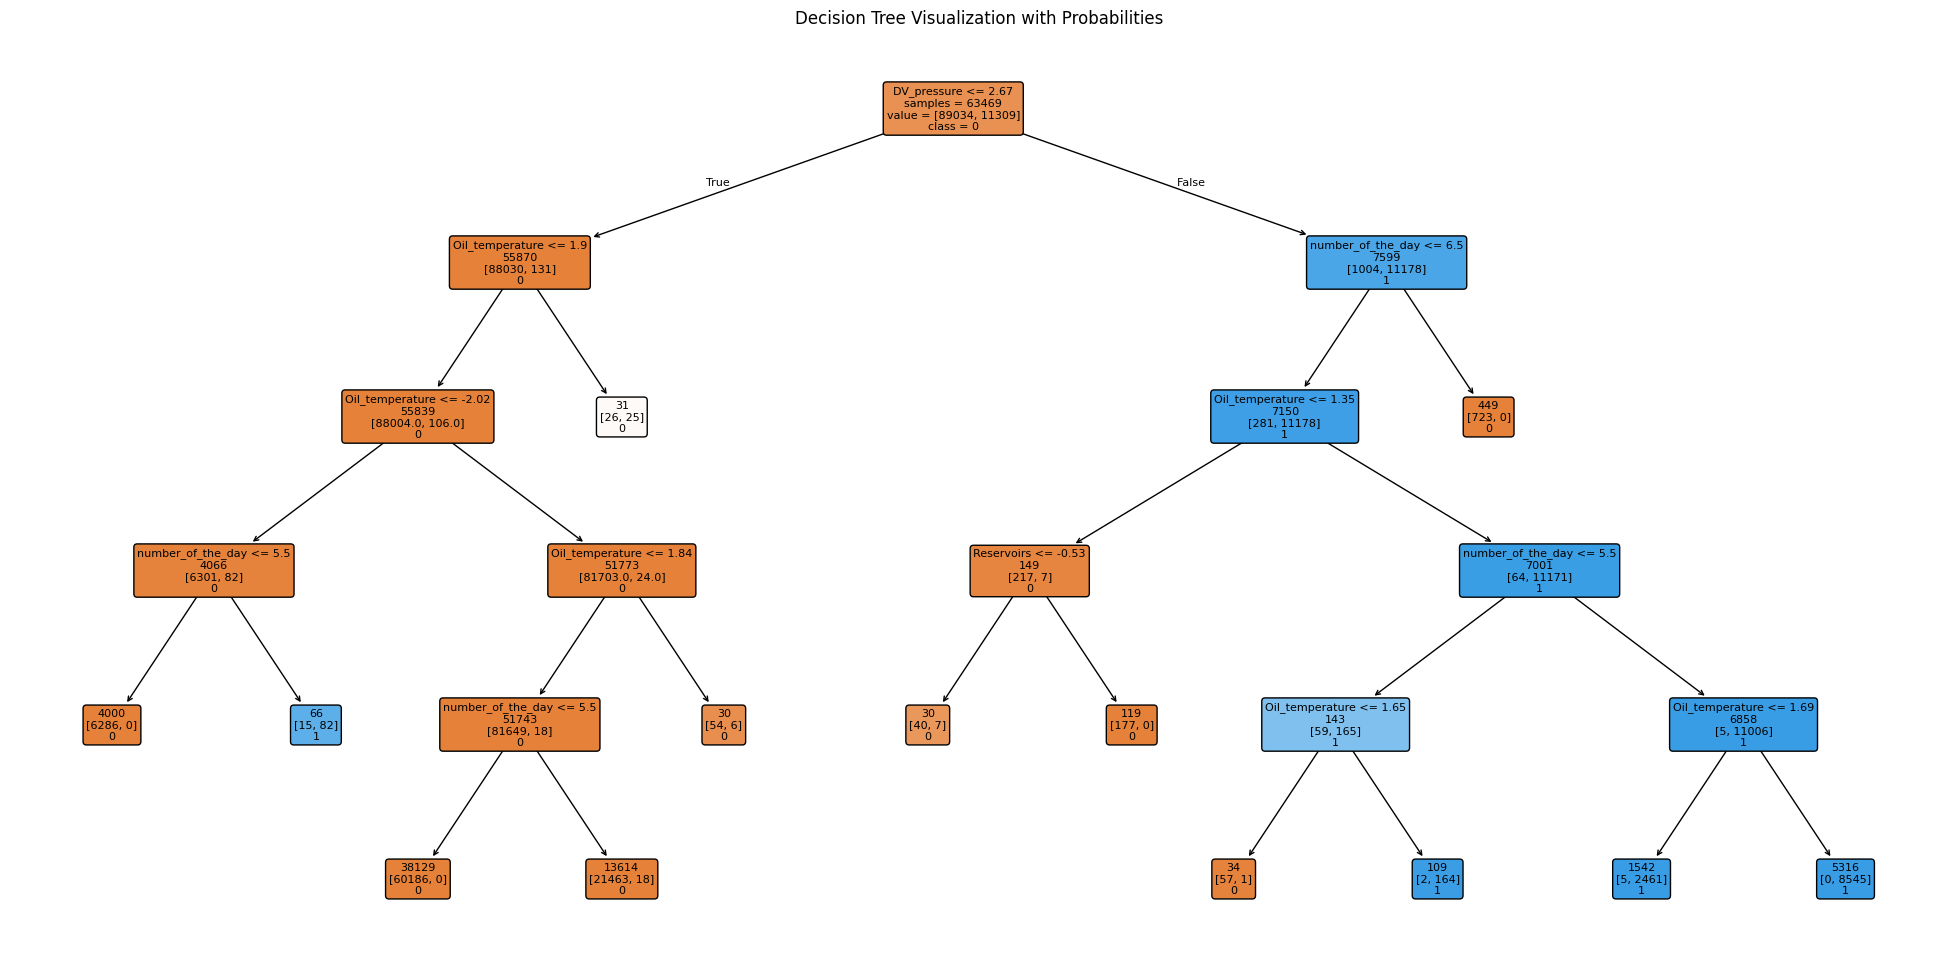

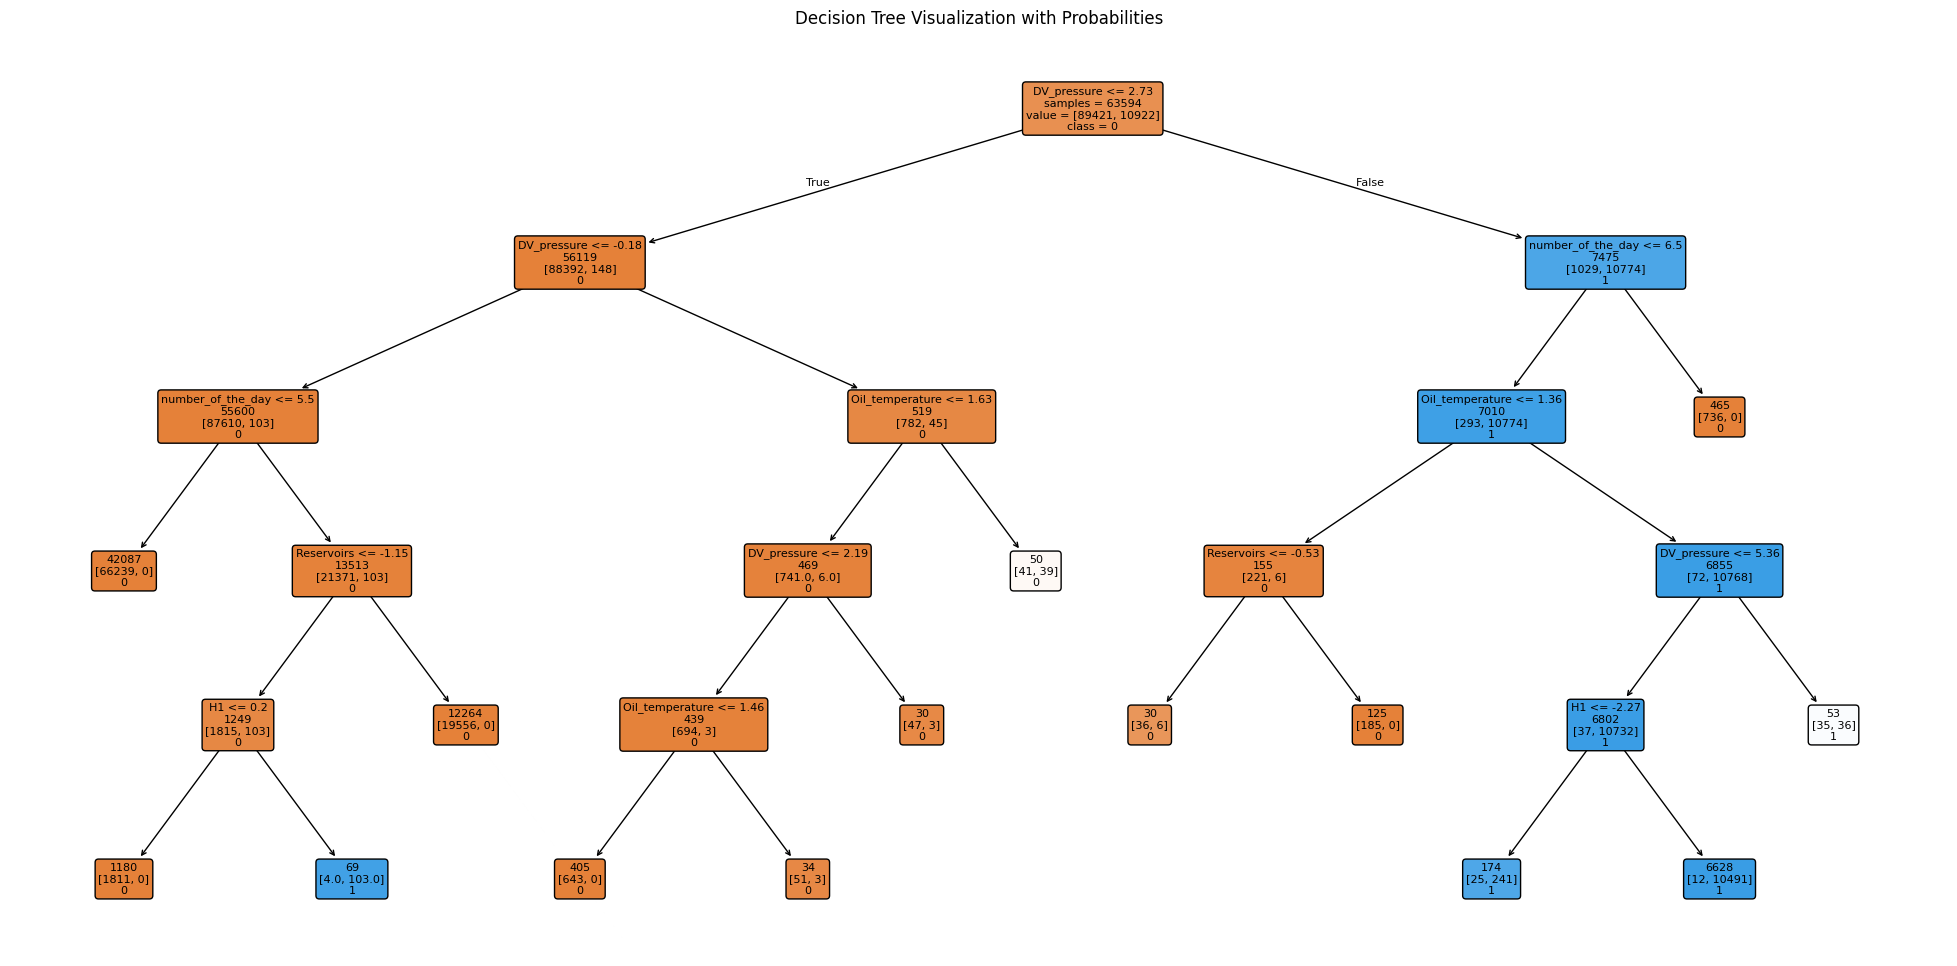

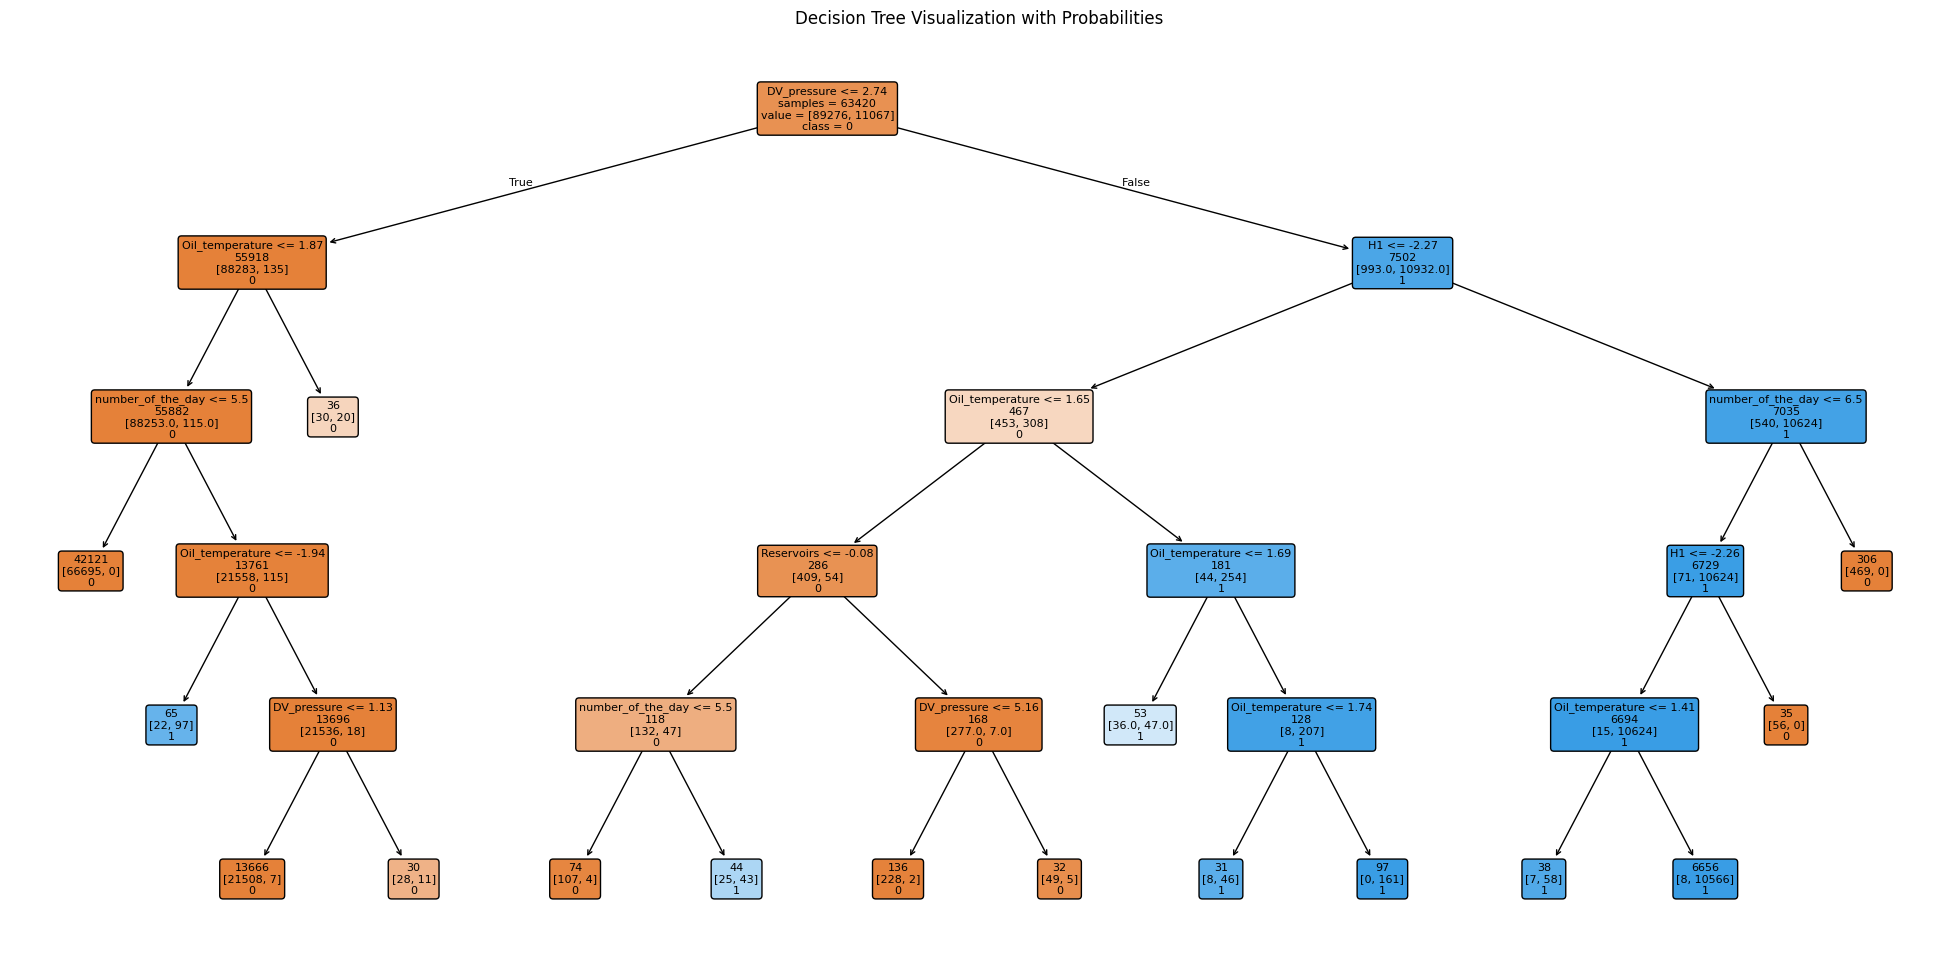

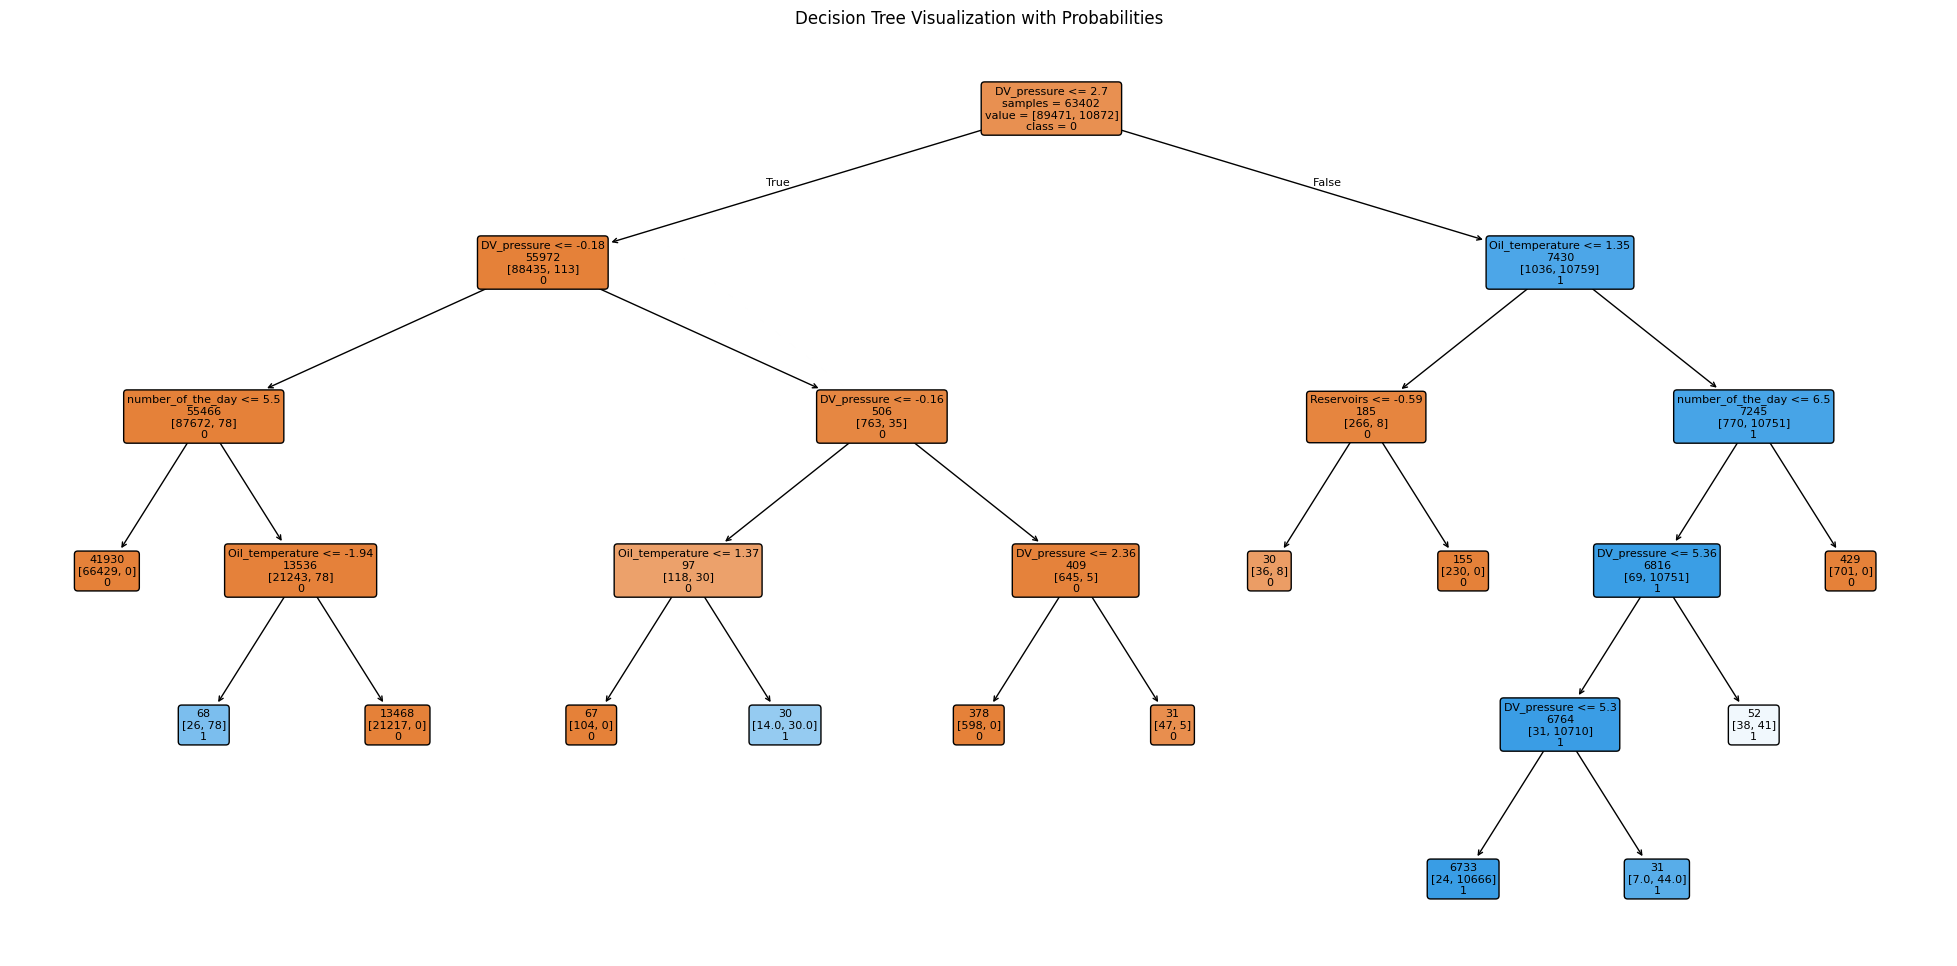

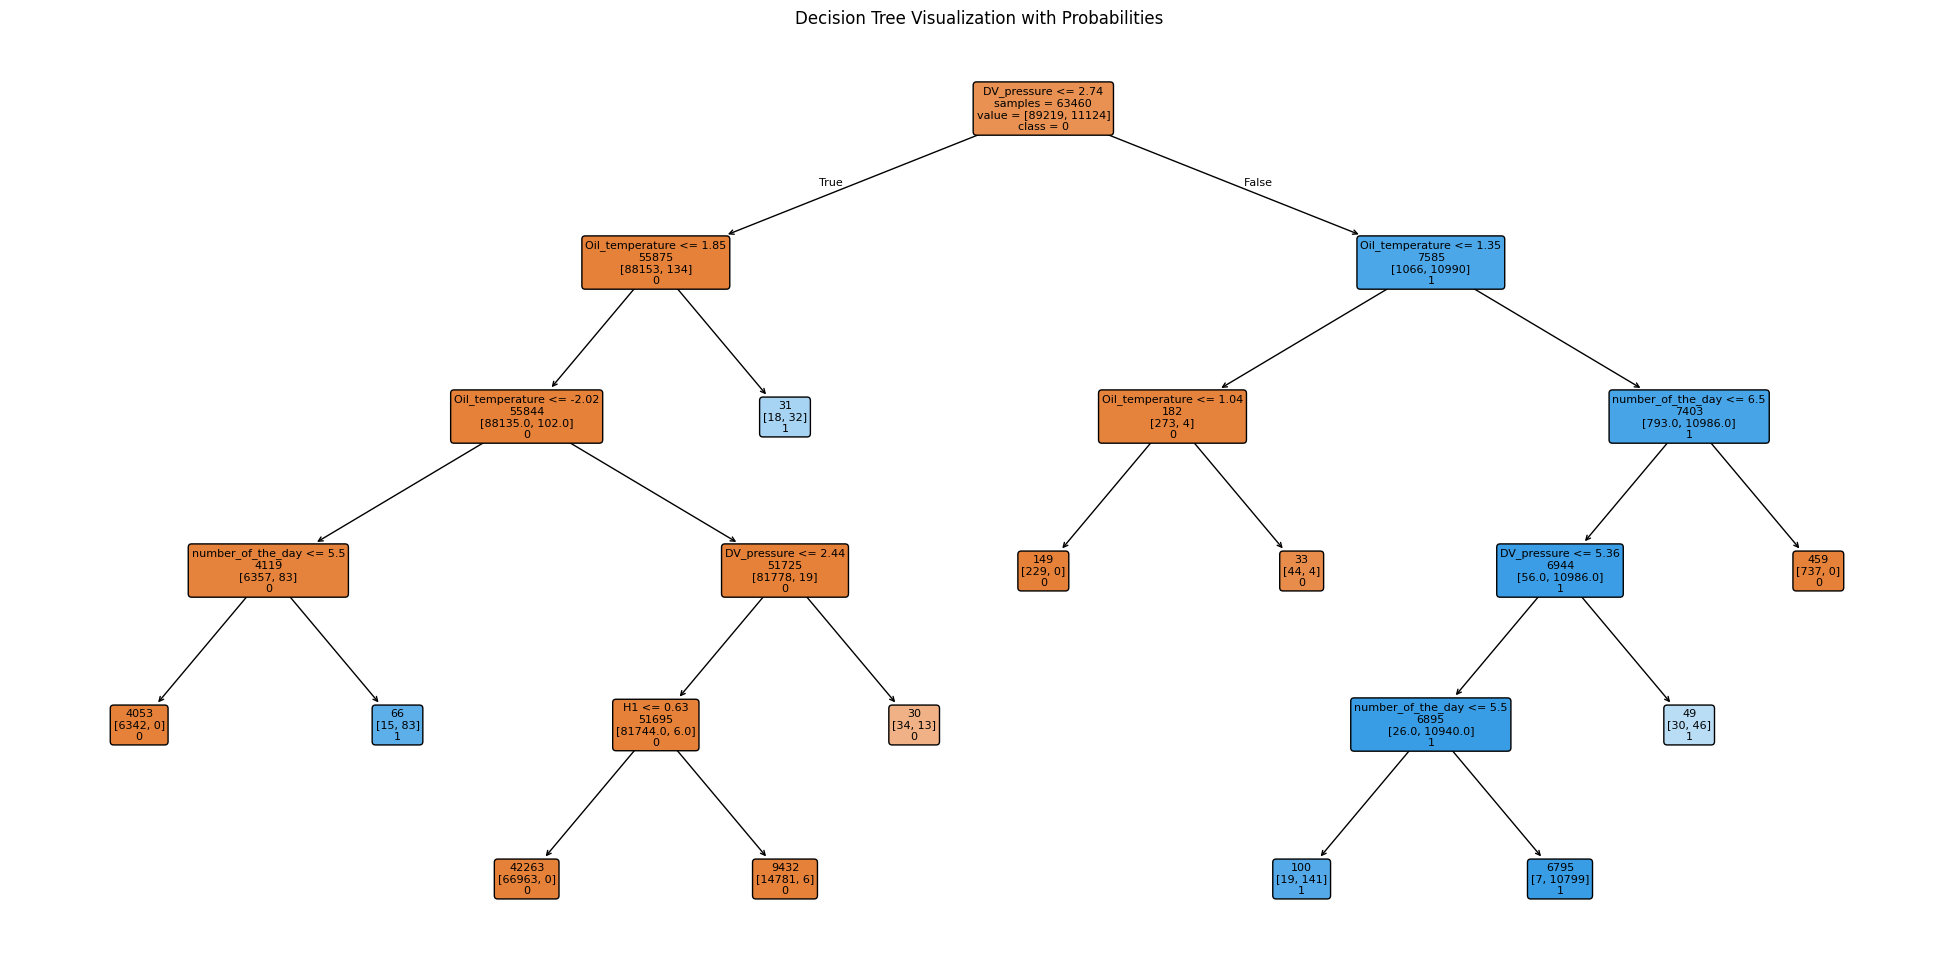

      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
4437      4437     443700   444099        400  0.000270          0
4438      4438     443800   444199        400  0.000269          0
4439      4439     443900   444299        400  0.000673          0
4440      4440     444000   444399        400  0.000752          0
4441      4441     444100   444447        348  0.000833          0

[4442 rows x 6 columns]


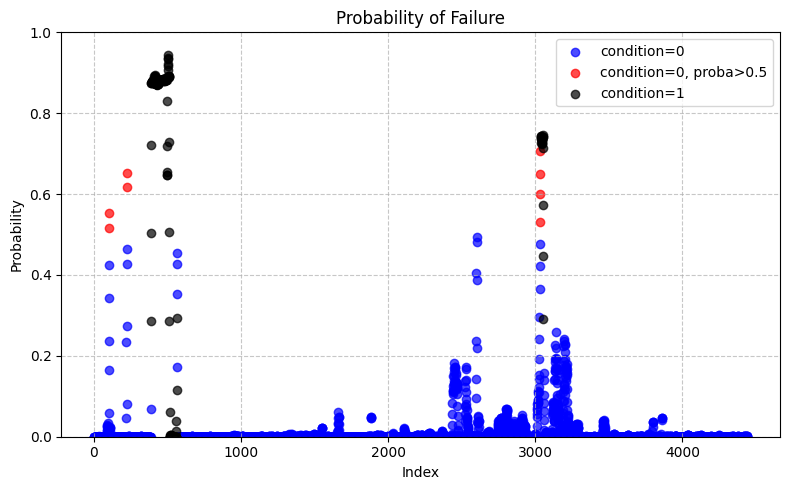

In [28]:
dataframe = df1.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)
aggregation_size = 400

treshold_probability = 0.5

aggregated_probabilities, f2 = agg_random_forest(5, 5, 5, 60, 30, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 18, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition2(aggregated_probabilities, treshold_probability)

RANDOM FOREST MODEL AFTER FEATURE IMPORTANCE STEPS WITH POST MAINTENANCE DATA

                     Importance
DV_pressure            0.897749
number_of_the_day      0.073745
Oil_temperature        0.026597
H1                     0.001785
Reservoirs             0.000124
Motor_current          0.000000
number_of_the_month    0.000000
R-squareddd: 0.993468795293106
F-Value Like: 2180295.4551952416
model preditions
[0 0 0 ... 0 0 0]
model proba
[0.00015672 0.00015672 0.00015672 ... 0.00015672 0.00015672 0.00015672]
        model_predictions  model_probablities
0                       0            0.000157
1                       0            0.000157
2                       0            0.000157
3                       0            0.000157
4                       0            0.000157
...                   ...                 ...
441619                  0            0.000157
441620                  0            0.000157
441621                  0            0.000157
441622                  0            0.000157
441623                  0            0.000157

[441624 

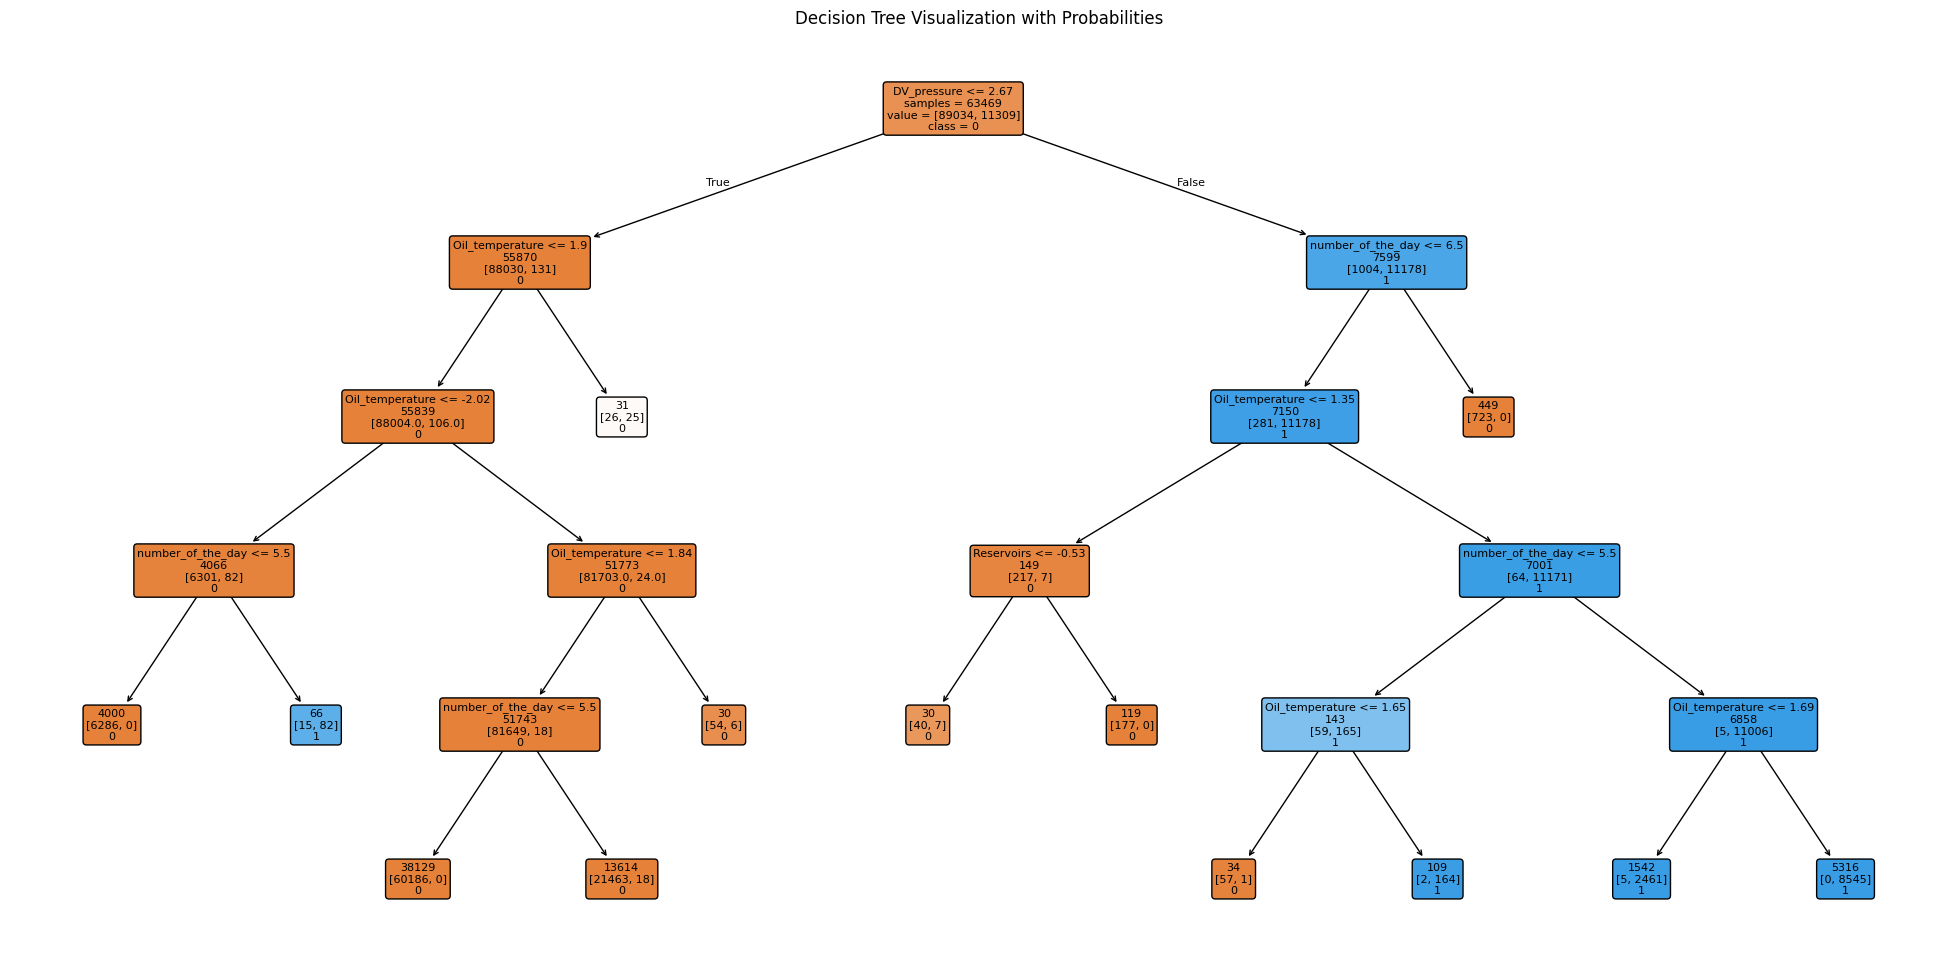

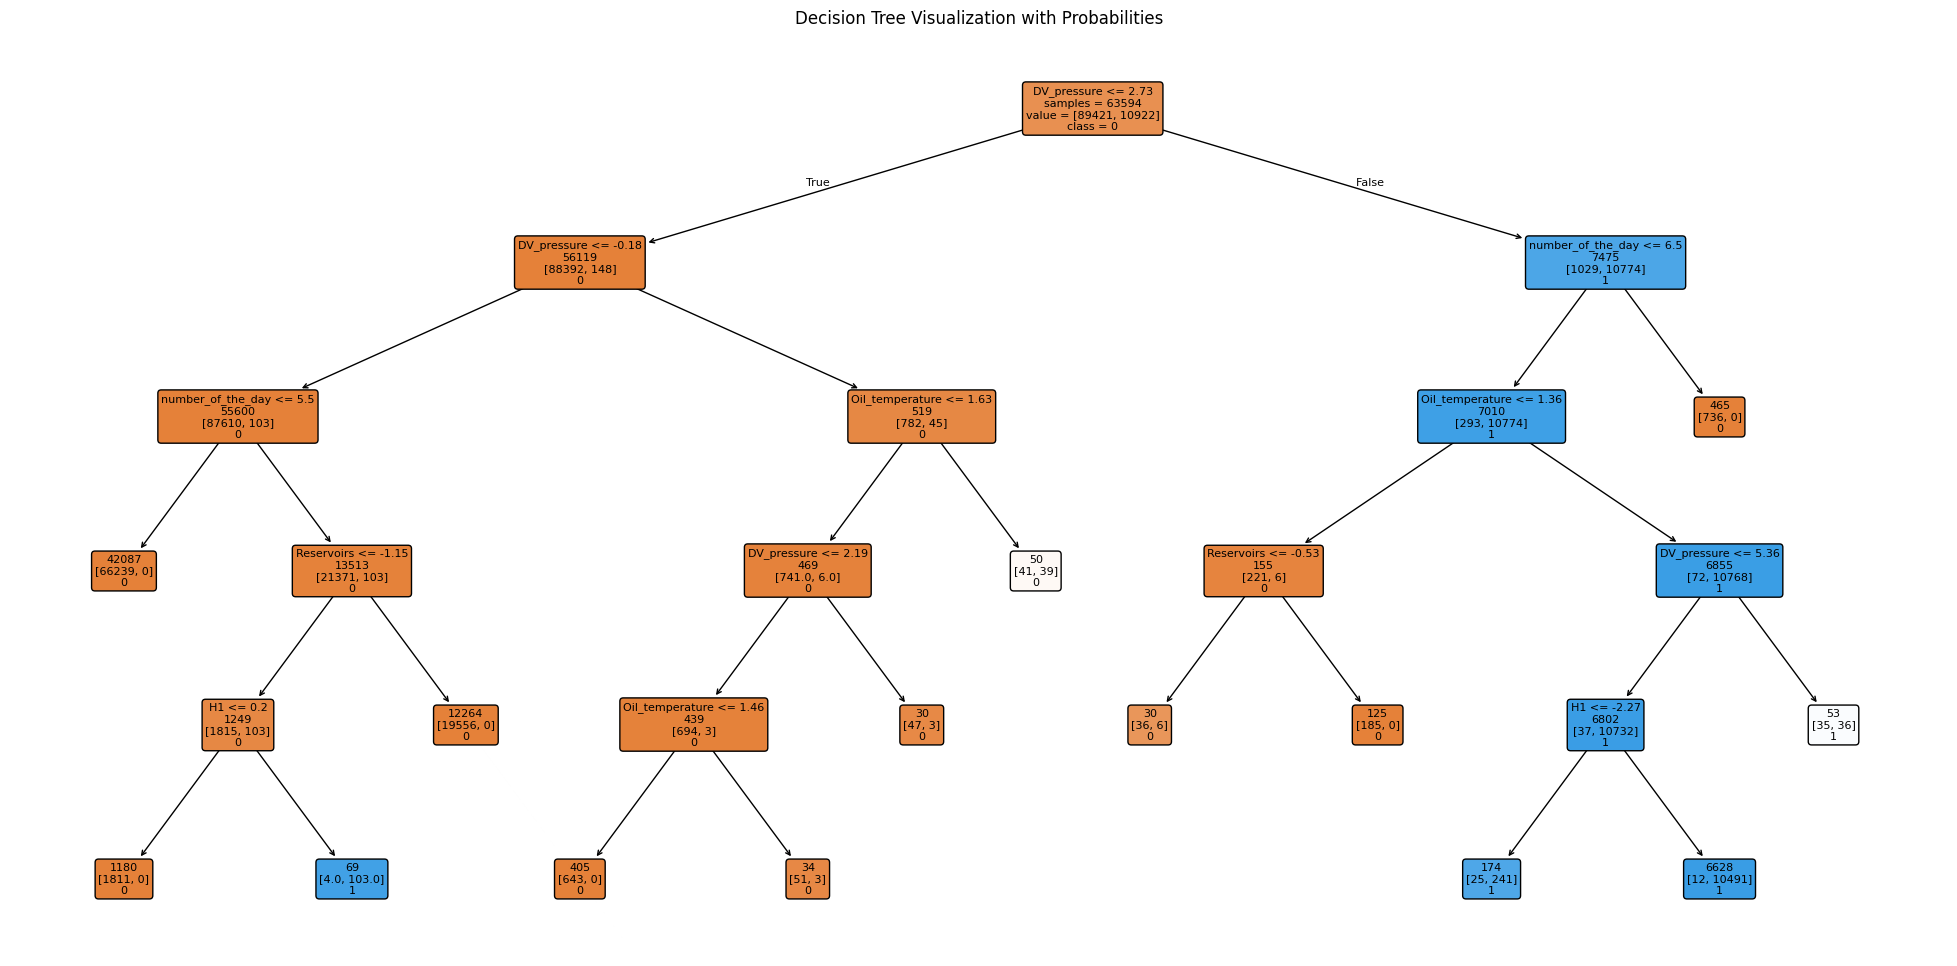

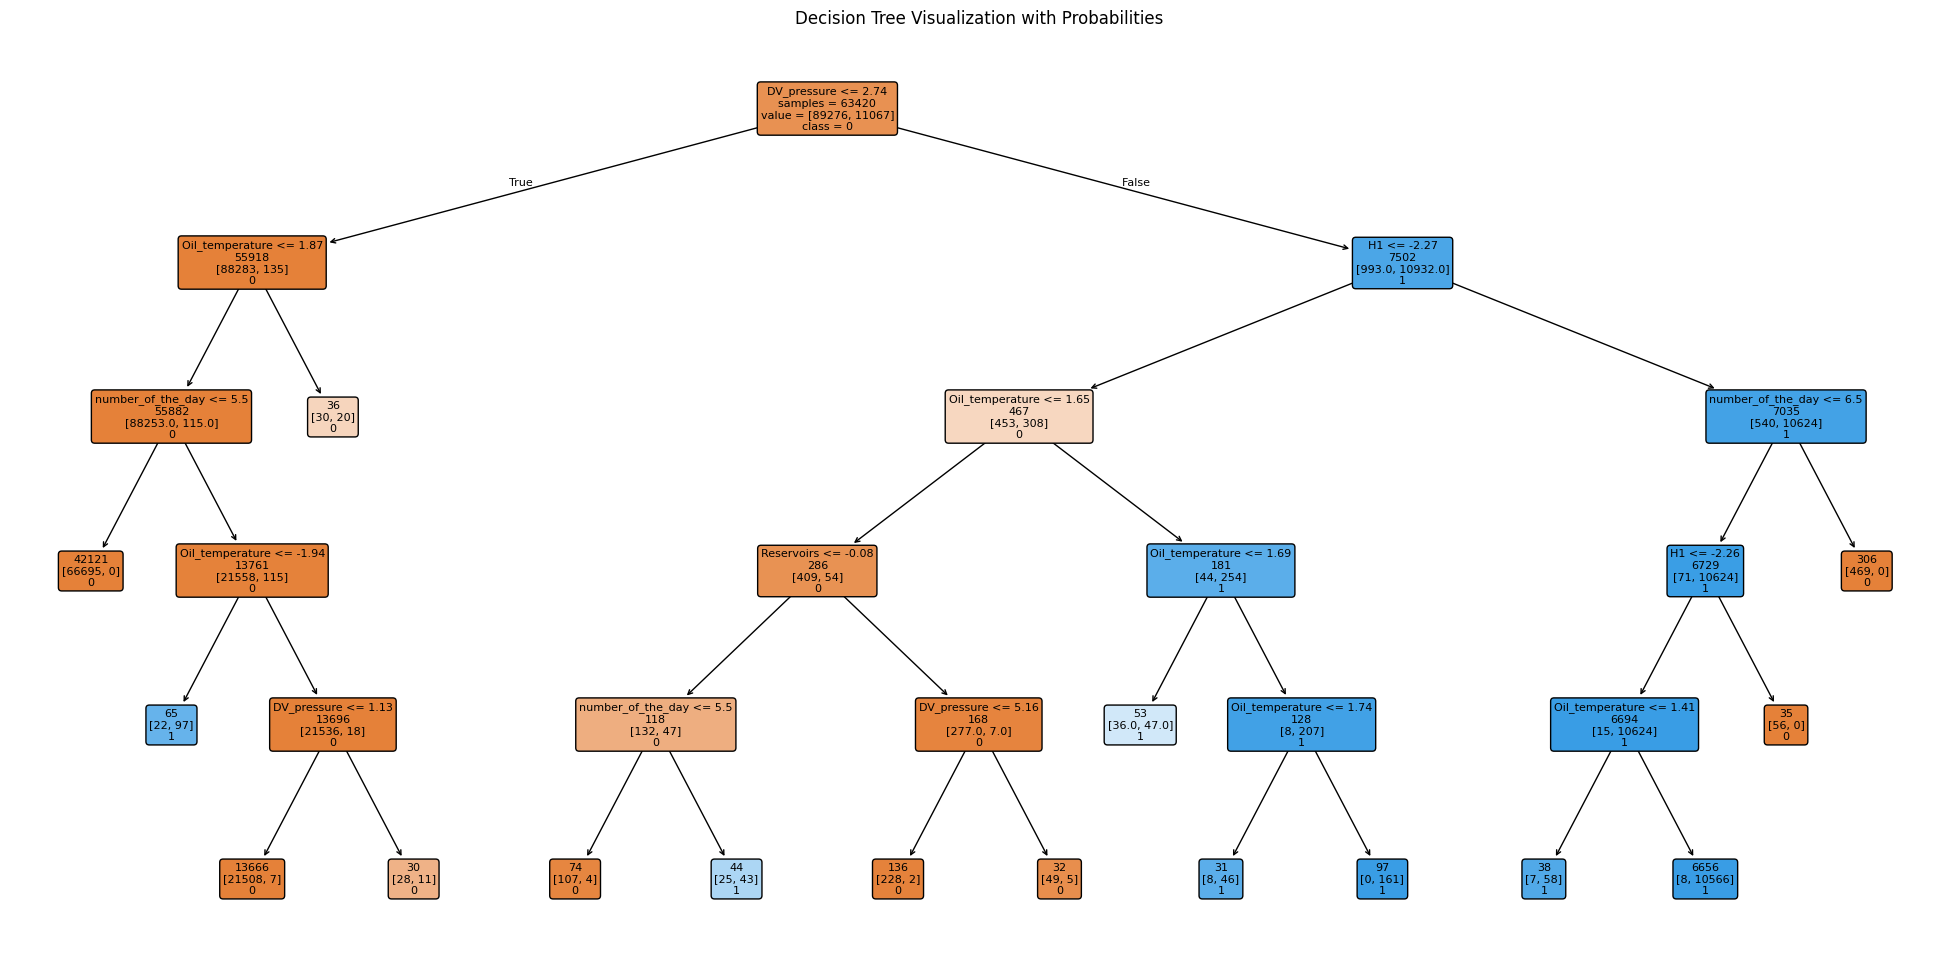

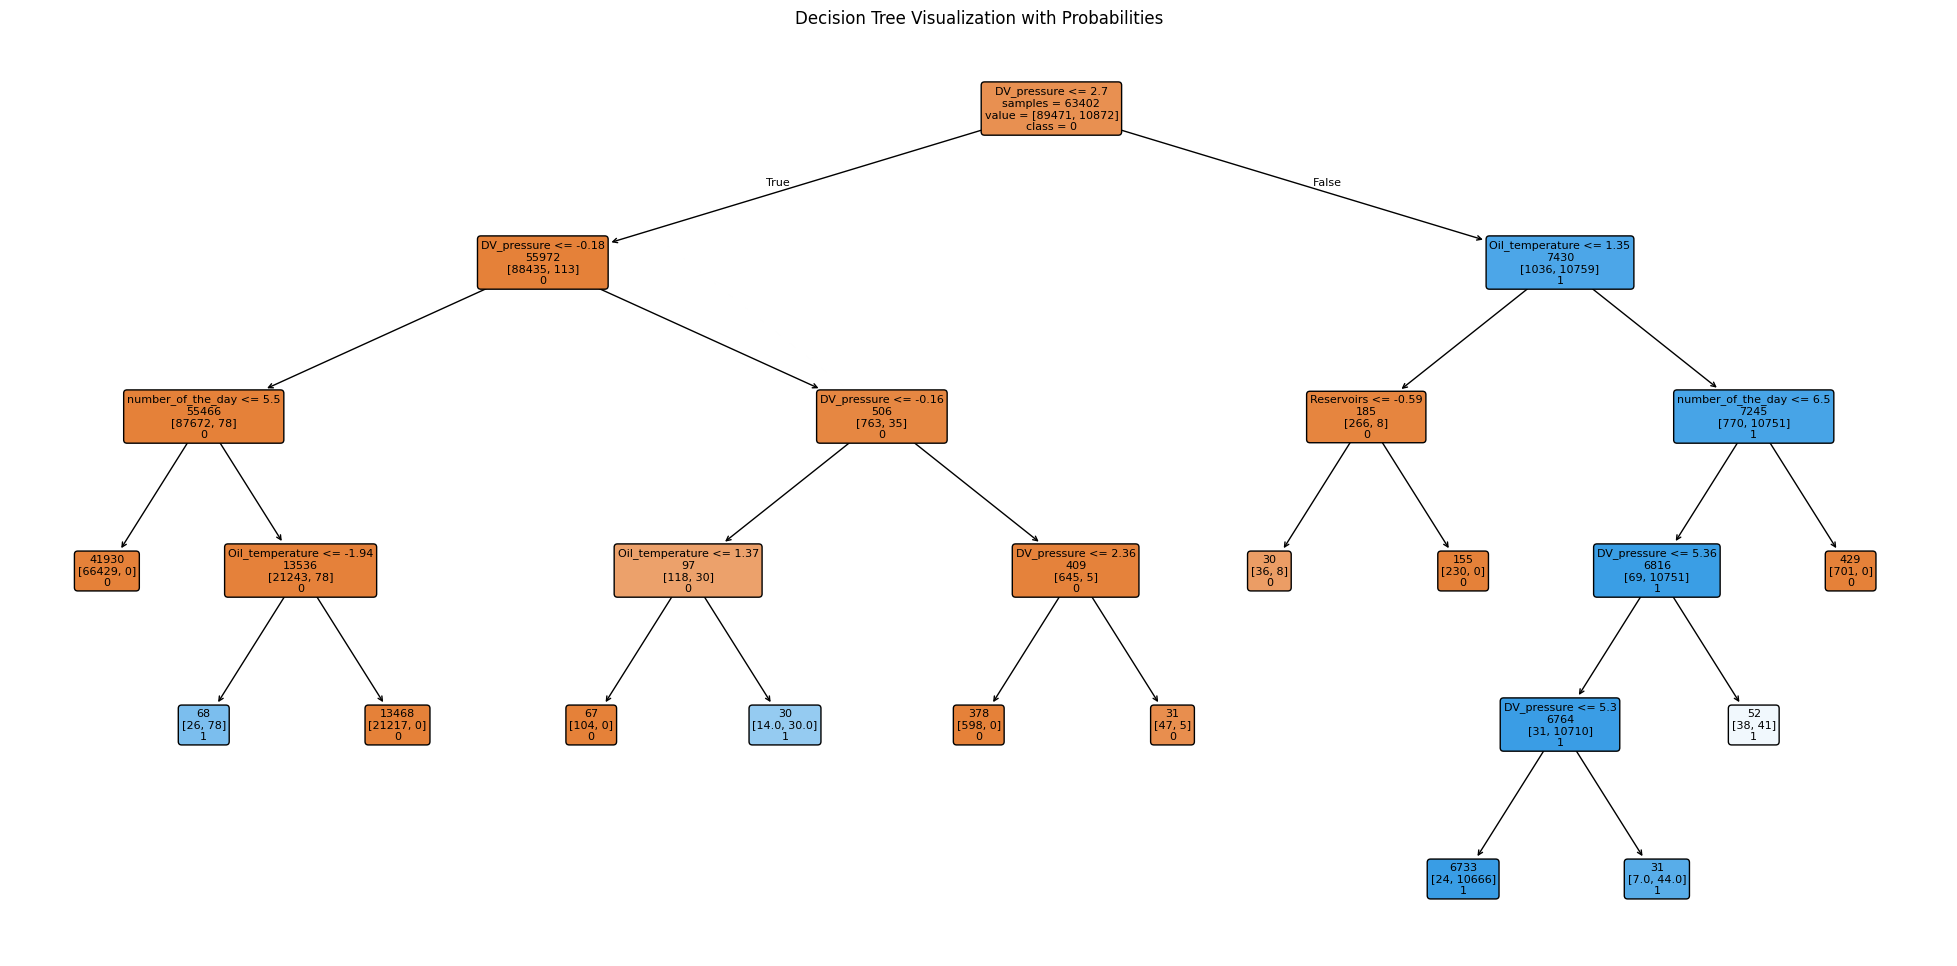

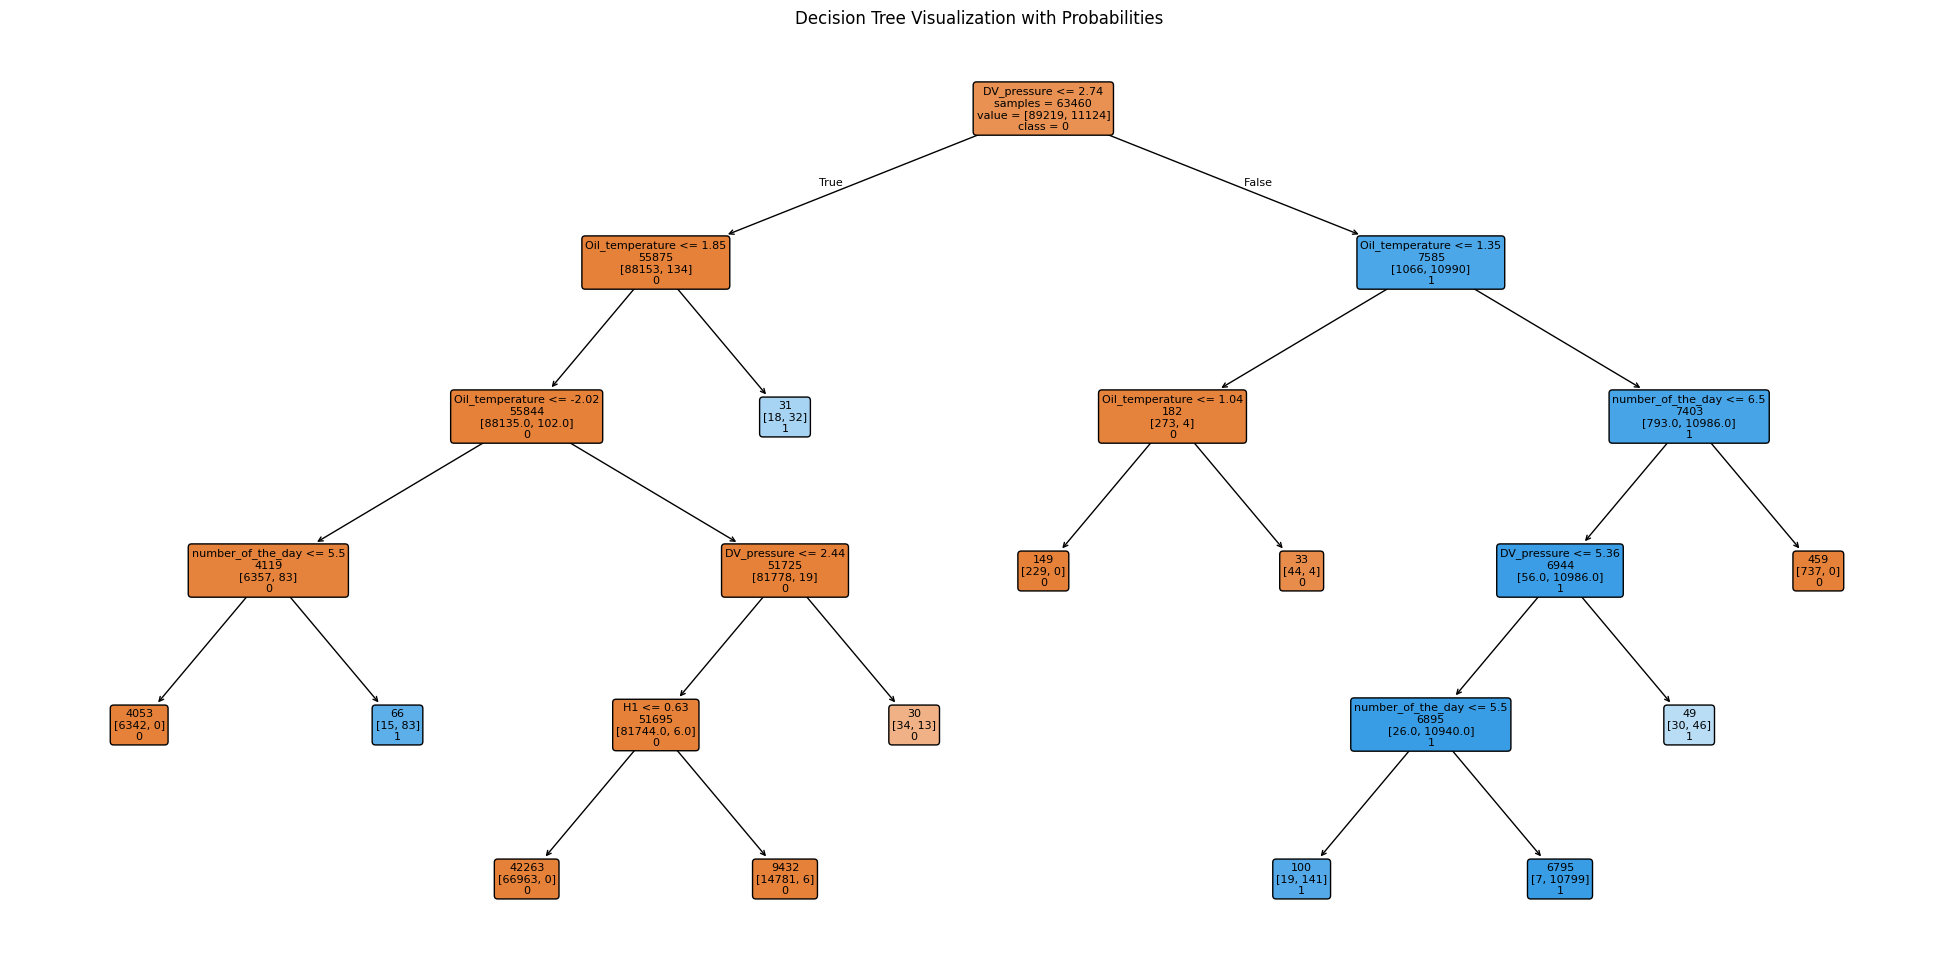

      group_id  start_row  end_row  row_count     proba  condition
0            0          0      399        400  0.000232          0
1            1        100      499        400  0.000236          0
2            2        200      599        400  0.000239          0
3            3        300      699        400  0.000240          0
4            4        400      799        400  0.000185          0
...        ...        ...      ...        ...       ...        ...
4409      4409     440900   441299        400  0.000372          0
4410      4410     441000   441399        400  0.000284          0
4411      4411     441100   441499        400  0.000284          0
4412      4412     441200   441599        400  0.000246          0
4413      4413     441300   441623        324  0.000171          0

[4414 rows x 6 columns]


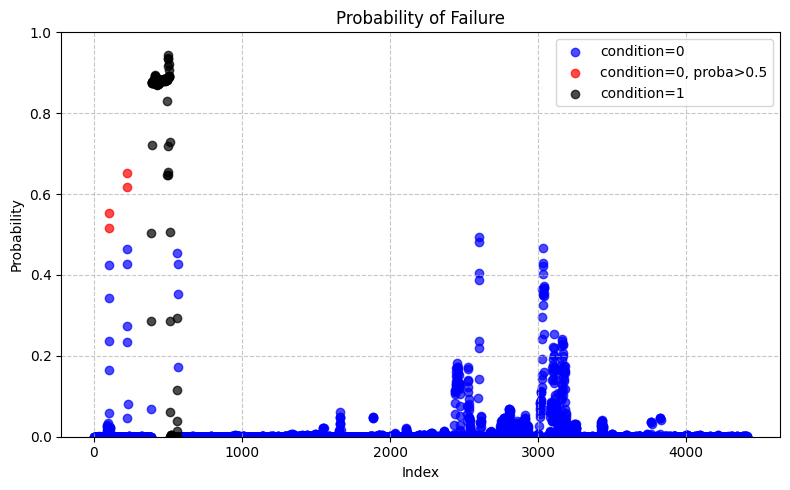

In [29]:
dataframe = df_simulated.drop(labels = [
    "DV_eletric", 
    "TP2",   
    "MPG", 
    "LPS", 
    "Pressure_switch", 
    "Oil_level", 
    "Caudal_impulses", 
    "number_of_the_week",
    "Towers",
    "TP3",
    "COMP",
], axis = 1)



aggregation_size = 400

treshold_probability = 0.5



aggregated_probabilities, f2 = agg_random_forest(5, 5, 5, 60, 30, dataframe, aggregation_size, 4, 2, 4, 2, 5, 18, 18, 18, "yes", "yes", "no", "no", 100)

plot_probabilities_by_condition2(aggregated_probabilities, treshold_probability)

LOGISTIC REGRESSION MODEL WITH ORIGINAL DATA

LOGISTIC REGRESSION MODEL WITH THE POST MAINTENANCE DATA OF THE 4TH FAILURE